In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import skimage.morphology

# Define the function to compute the boundaries based on a mathematical morphology
def computeBoundaries(signal, th):
    locs = np.where(signal > th)[0]
    indexes = np.zeros((signal.shape[0], 1))
    indexes[locs] = 1

    # Morphological operations
    selem = np.ones((70, 1))
    closed = skimage.morphology.closing(indexes, selem)
    opened = skimage.morphology.opening(closed, selem)

    locsNew = np.where(opened == 1)[0]
    derNew = np.diff(locsNew)
    ind = np.where(derNew > 1)[0]

    ending = np.append(locsNew[ind], locsNew[-1])
    starting = np.append(locsNew[0], locsNew[ind + 1])

    return starting, ending

def plot_and_segment_cube_signals(cube_number, threshold):
    cube_name = f'Cube{cube_number}'
    cube_path = os.path.join(base_path, cube_name)

    global segmented_data_dict  # Use the global dictionary to store results

    sampling_rate = 200000  # 200,000 Hz
    time_step = 1 / sampling_rate  # Time step in seconds

    # 10 conditions, with 2 subplots (for channels 0 and 1) per condition
    fig, axes = plt.subplots(10, 2, figsize=(12, 40))
    fig.suptitle(f'{cube_name} Signals with Segment Markers', fontsize=16)

    for i in range(10):  # For each condition
        # Load channel data
        data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{i}.csv')).to_numpy().flatten()
        data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{i}.csv')).to_numpy().flatten()

        # Calculate time array for plotting
        time_array = np.arange(data_channel_0.size) * time_step

        # Use channel 1 to find boundaries
        starting_1, ending_1 = computeBoundaries(data_channel_1, threshold)
        num_segments = len(starting_1)
        segment_sizes = ending_1 - starting_1
        avg_size = np.mean(segment_sizes)
        std_dev = np.std(segment_sizes)

        # Print the statistics for the segments
        print(f'Condition {i+1}: Found {num_segments} segments, Avg. Size: {avg_size:.2f}, Std. Dev: {std_dev:.2f}')

        # Plot signals with markers
        for j, (channel_data, time) in enumerate([(data_channel_0, time_array), (data_channel_1, time_array)]):
            ax = axes[i, j]
            ax.plot(time, channel_data)
            param_set = params_dict[cube_name][i]
            title = f'Cond {i+1}: {param_set["Power (W)"]}W, {param_set["Speed (mm/s)"]}mm/s'
            ax.set_title(title)
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(f'Signal - channel_{j}')
            # Add markers for the start and end of each segment
            for start in starting_1:
                ax.axvline(x=time_array[start], color='green', linestyle='--')
            for end in ending_1:
                ax.axvline(x=time_array[end], color='red', linestyle='--')

        # Segment both channels using the computed boundaries and organize the data into a tensor
        min_size = min(segment_sizes)
        max_size = max(segment_sizes)
        print(f"Segment Max Size: {max_size}, Segment Min Size: {min_size}")
        data_tensor = np.zeros((num_segments, 2, min_size))
        for seg_index, start in enumerate(starting_1):
            end = start + min_size
            data_tensor[seg_index, 0, :] = data_channel_0[start:end]
            data_tensor[seg_index, 1, :] = data_channel_1[start:end]

        # Store in the dictionary with parameters as keys
        key = (param_set['Power (W)'], param_set['Speed (mm/s)'], cube_number)
        segmented_data_dict[key] = data_tensor

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [2]:
# Path to data
base_path = './Data/Neuchatel_316L'


In [3]:
# Load parameters from Excel into a dictionary
excel_path = './experiment_parameters.xlsx'
xl = pd.ExcelFile(excel_path)
params_dict = {}
for sheet_name in xl.sheet_names:
    df = xl.parse(sheet_name)
    params_dict[sheet_name] = df[['Speed (mm/s)', 'Power (W)', 'Power perc (%)']].to_dict('records')

params_dict

{'Cube1': [{'Speed (mm/s)': 1050, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 800, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1800, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 550, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 800, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1050, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 1550, 'Power (W)': 90, 'Power perc (%)': 18},
  {'Speed (mm/s)': 1800, 'Power (W)': 105, 'Power perc (%)': 21}],
 'Cube2': [{'Speed (mm/s)': 800, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 300, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 1300, 'Power (W)': 105, 'Power perc (%)': 21},
  {'Speed (mm/s)': 1050, 'Power (W)': 120, 'Power perc (%)': 24},
  {'Speed (mm/s)': 300, 'Power (W)': 105, 'Power perc (%)': 21},
 

In [4]:
# Initialize the dictionary to hold the segmented data tensors
segmented_data_dict = {}


Working on cube 1
Condition 1: Found 10 segments, Avg. Size: 2250.40, Std. Dev: 36.45
Segment Max Size: 2332, Segment Min Size: 2213
Condition 2: Found 10 segments, Avg. Size: 2797.50, Std. Dev: 1.96
Segment Max Size: 2801, Segment Min Size: 2795
Condition 3: Found 10 segments, Avg. Size: 1408.60, Std. Dev: 0.80
Segment Max Size: 1410, Segment Min Size: 1407
Condition 4: Found 10 segments, Avg. Size: 1836.80, Std. Dev: 1.33
Segment Max Size: 1839, Segment Min Size: 1835
Condition 5: Found 10 segments, Avg. Size: 3641.70, Std. Dev: 8.43
Segment Max Size: 3661, Segment Min Size: 3636
Condition 6: Found 10 segments, Avg. Size: 2498.80, Std. Dev: 0.87
Segment Max Size: 2500, Segment Min Size: 2498
Condition 7: Found 10 segments, Avg. Size: 1535.40, Std. Dev: 0.66
Segment Max Size: 1537, Segment Min Size: 1535
Condition 8: Found 10 segments, Avg. Size: 1902.30, Std. Dev: 0.46
Segment Max Size: 1903, Segment Min Size: 1902
Condition 9: Found 10 segments, Avg. Size: 1287.20, Std. Dev: 0.60
Se

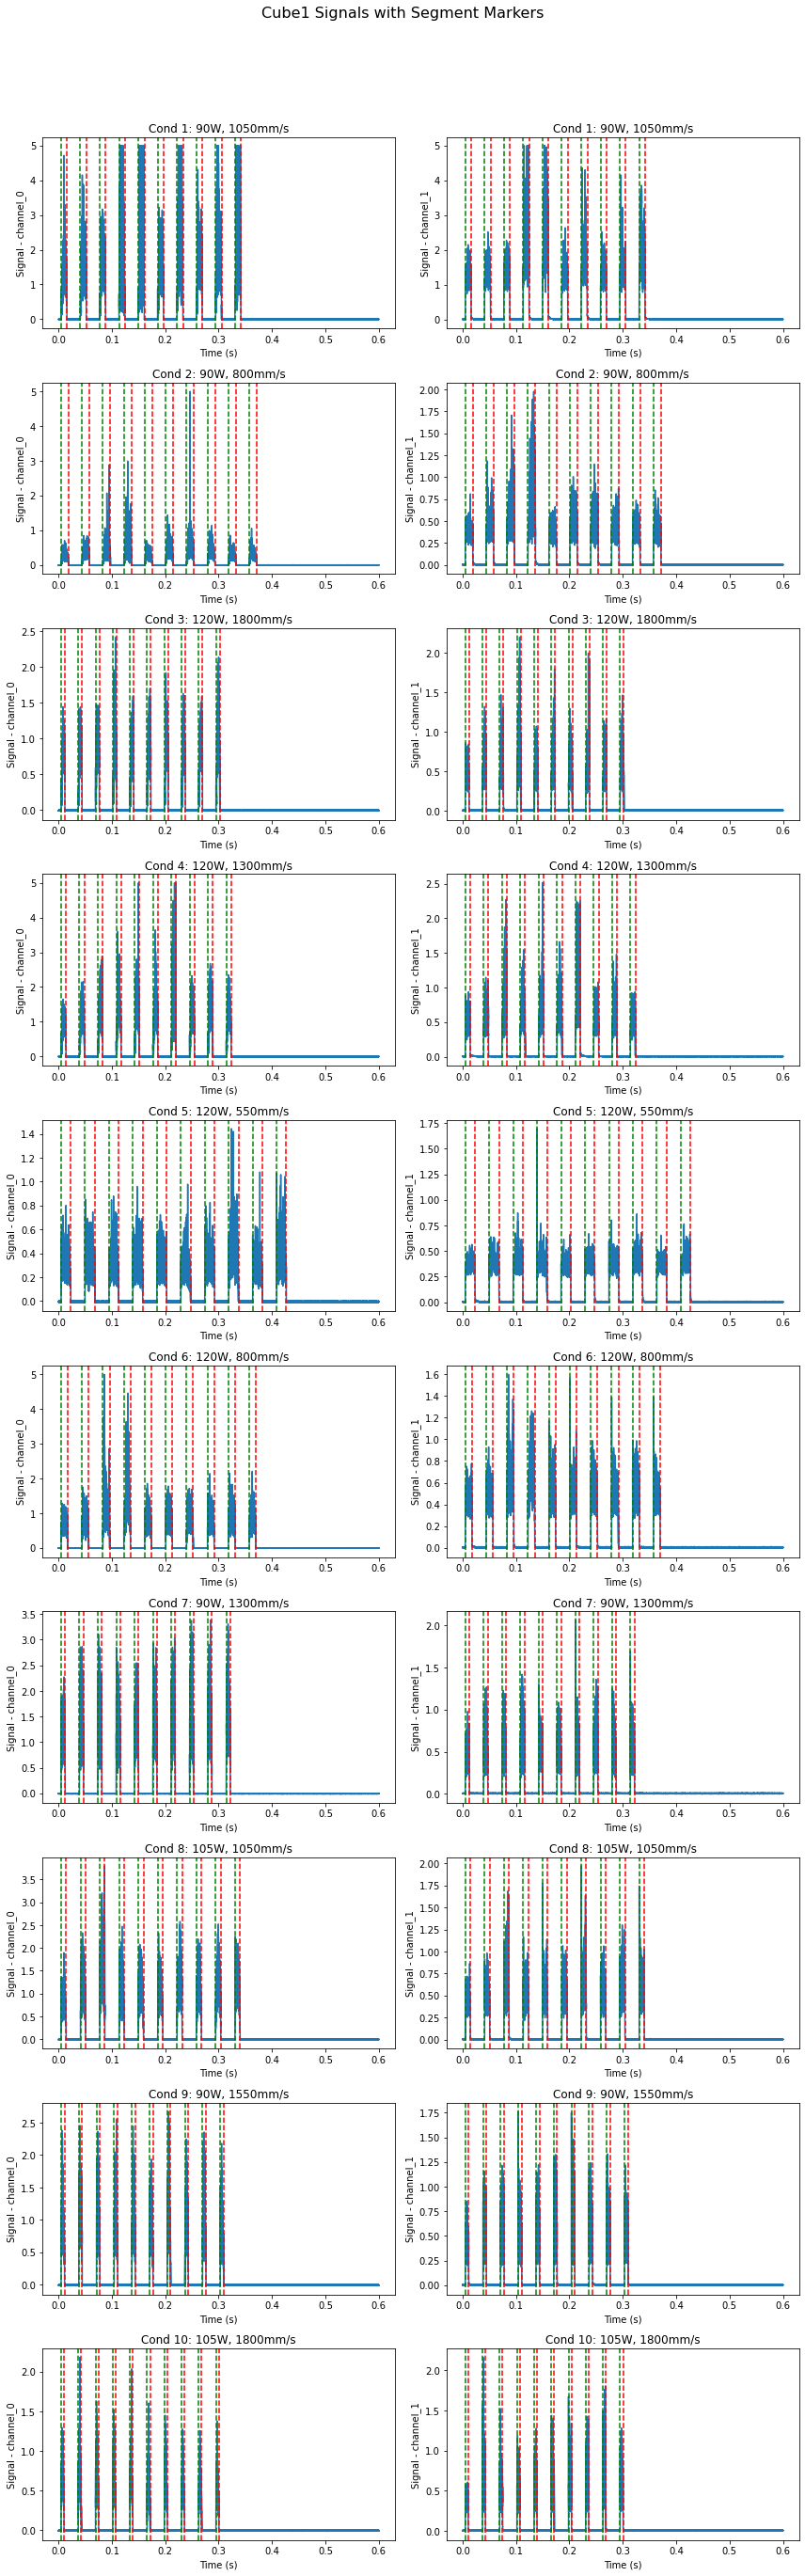

------------------------------
Working on cube 2
Condition 1: Found 11 segments, Avg. Size: 2498.45, Std. Dev: 12.22
Segment Max Size: 2526, Segment Min Size: 2469
Condition 2: Found 10 segments, Avg. Size: 6684.00, Std. Dev: 13.44
Segment Max Size: 6720, Segment Min Size: 6671
Condition 3: Found 10 segments, Avg. Size: 1536.10, Std. Dev: 0.54
Segment Max Size: 1537, Segment Min Size: 1535
Condition 4: Found 10 segments, Avg. Size: 1905.10, Std. Dev: 1.76
Segment Max Size: 1908, Segment Min Size: 1902
Condition 5: Found 10 segments, Avg. Size: 6693.60, Std. Dev: 21.90
Segment Max Size: 6735, Segment Min Size: 6666
Condition 6: Found 10 segments, Avg. Size: 3638.30, Std. Dev: 5.97
Segment Max Size: 3651, Segment Min Size: 3634
Condition 7: Found 10 segments, Avg. Size: 1289.60, Std. Dev: 0.92
Segment Max Size: 1291, Segment Min Size: 1288
Condition 8: Found 10 segments, Avg. Size: 1290.10, Std. Dev: 1.14
Segment Max Size: 1292, Segment Min Size: 1289
Condition 9: Found 10 segments, Avg.

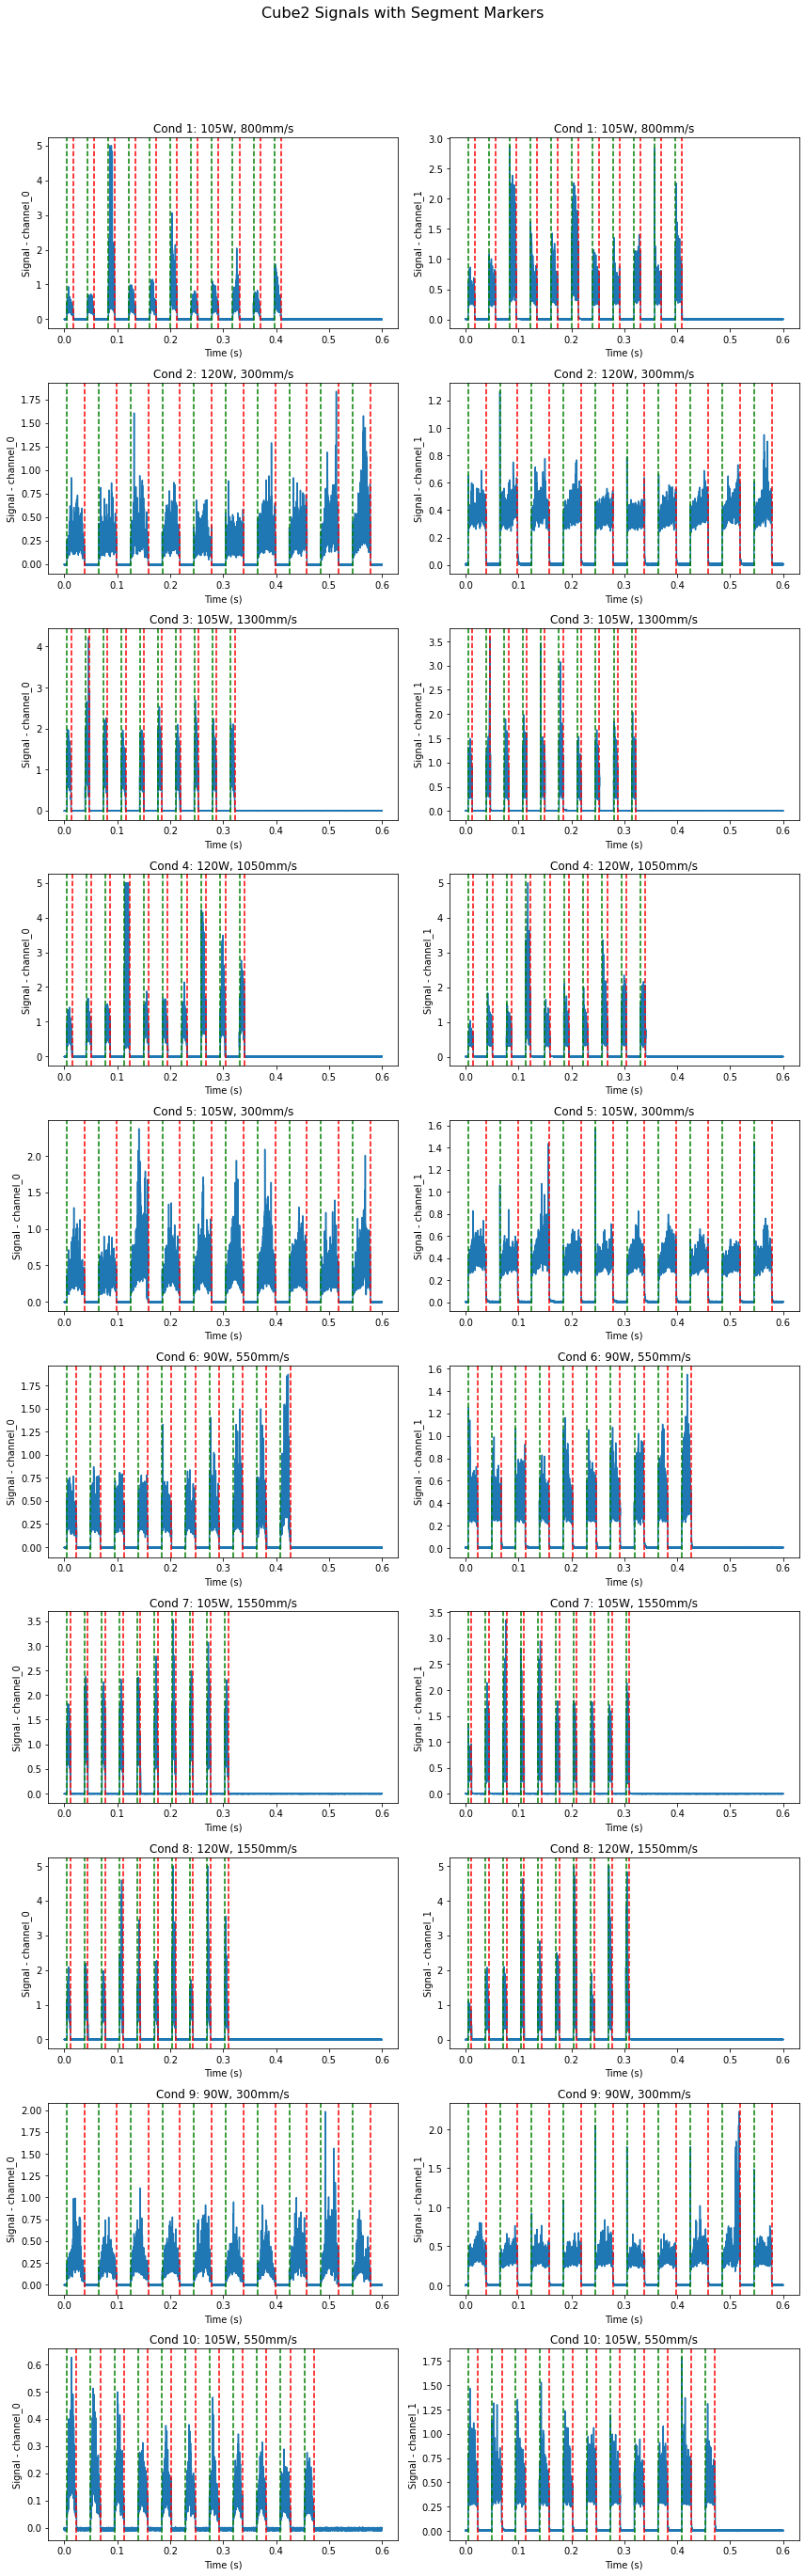

------------------------------
Working on cube 3
Condition 1: Found 10 segments, Avg. Size: 1284.90, Std. Dev: 8.32
Segment Max Size: 1289, Segment Min Size: 1260
Condition 2: Found 10 segments, Avg. Size: 1537.30, Std. Dev: 0.90
Segment Max Size: 1539, Segment Min Size: 1536
Condition 3: Found 10 segments, Avg. Size: 1901.70, Std. Dev: 0.78
Segment Max Size: 1903, Segment Min Size: 1901
Condition 4: Found 10 segments, Avg. Size: 6682.20, Std. Dev: 8.82
Segment Max Size: 6697, Segment Min Size: 6673
Condition 5: Found 10 segments, Avg. Size: 3639.70, Std. Dev: 5.33
Segment Max Size: 3655, Segment Min Size: 3635
Condition 6: Found 10 segments, Avg. Size: 1903.80, Std. Dev: 0.87
Segment Max Size: 1905, Segment Min Size: 1903
Condition 7: Found 10 segments, Avg. Size: 1109.30, Std. Dev: 0.46
Segment Max Size: 1110, Segment Min Size: 1109
Condition 8: Found 10 segments, Avg. Size: 6675.90, Std. Dev: 8.63
Segment Max Size: 6697, Segment Min Size: 6665
Condition 9: Found 10 segments, Avg. Si

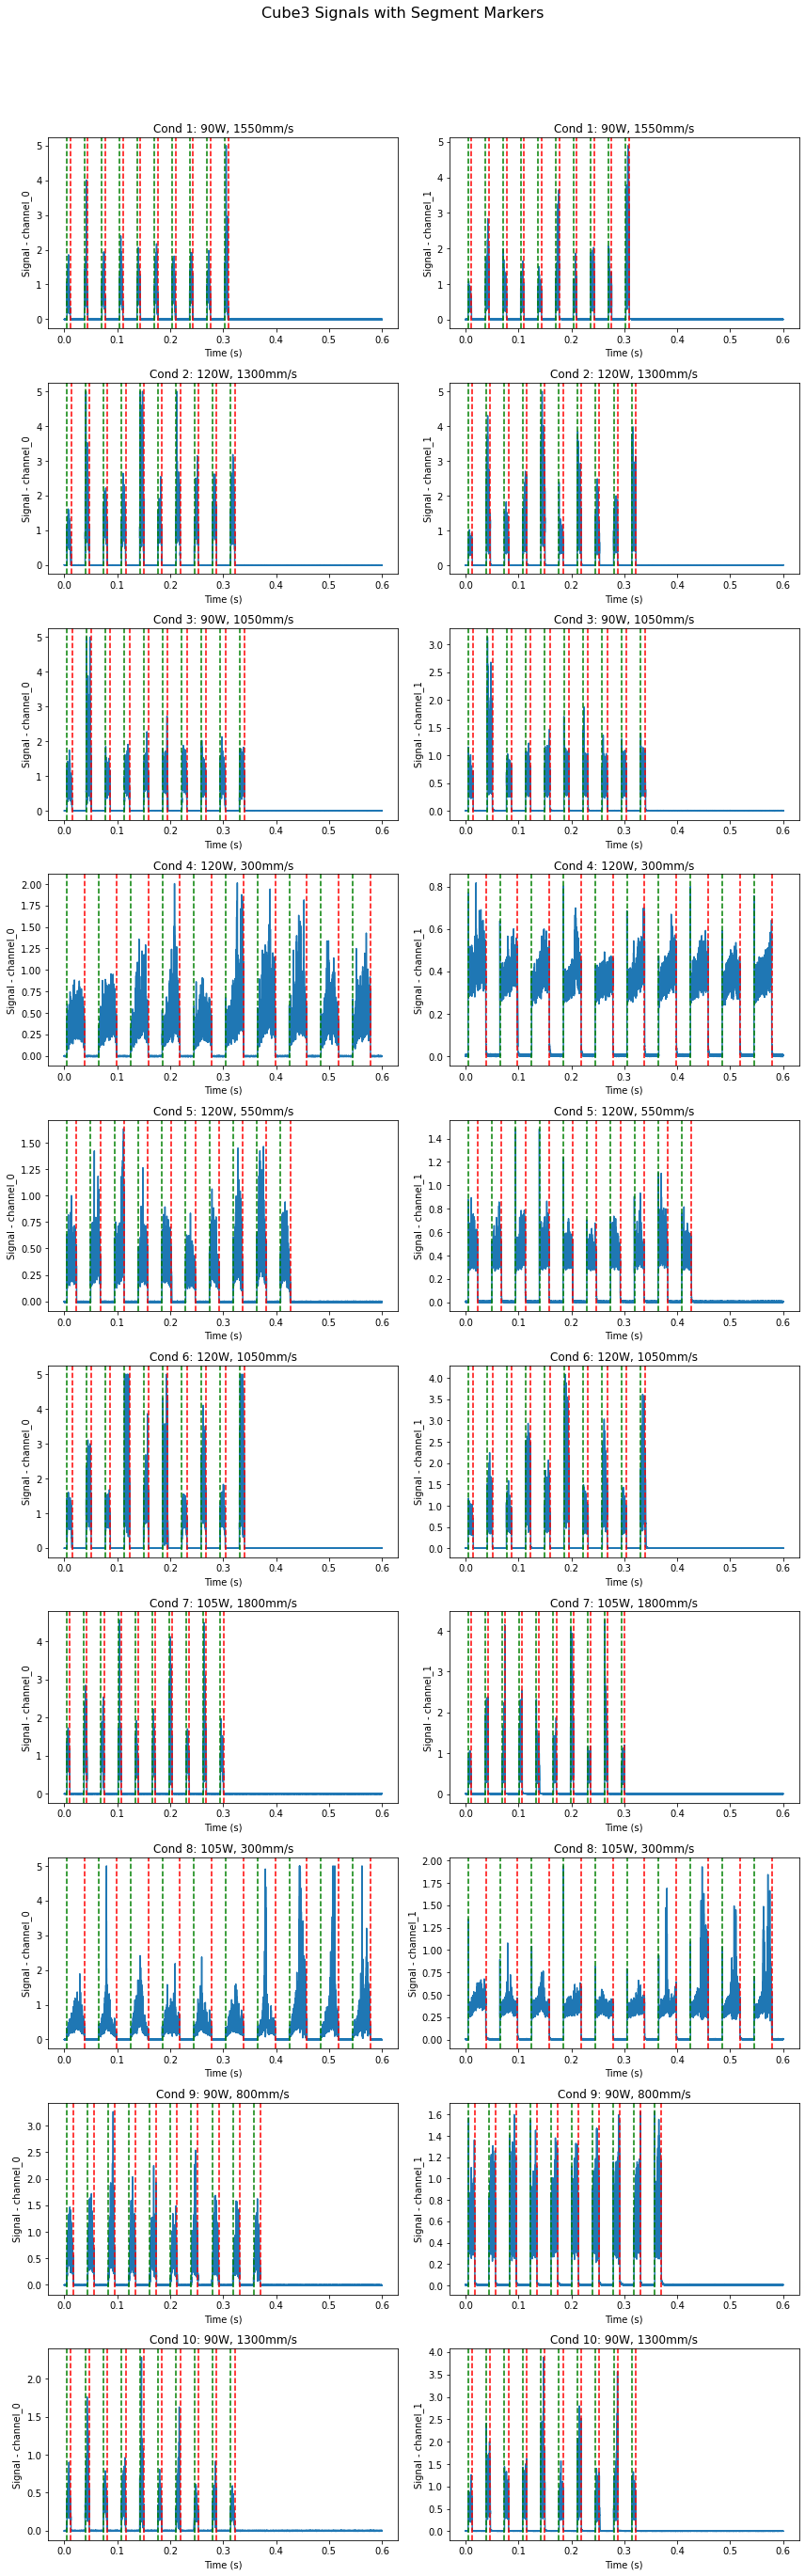

------------------------------
Working on cube 4
Condition 1: Found 10 segments, Avg. Size: 2496.10, Std. Dev: 9.74
Segment Max Size: 2501, Segment Min Size: 2467
Condition 2: Found 10 segments, Avg. Size: 2500.00, Std. Dev: 2.72
Segment Max Size: 2508, Segment Min Size: 2498
Condition 3: Found 10 segments, Avg. Size: 1905.50, Std. Dev: 5.39
Segment Max Size: 1921, Segment Min Size: 1902
Condition 4: Found 10 segments, Avg. Size: 1289.80, Std. Dev: 3.37
Segment Max Size: 1299, Segment Min Size: 1287
Condition 5: Found 10 segments, Avg. Size: 3685.40, Std. Dev: 50.45
Segment Max Size: 3804, Segment Min Size: 3639
Condition 6: Found 10 segments, Avg. Size: 6752.00, Std. Dev: 88.26
Segment Max Size: 6957, Segment Min Size: 6664
Condition 7: Found 10 segments, Avg. Size: 1116.30, Std. Dev: 5.75
Segment Max Size: 1131, Segment Min Size: 1110
Condition 8: Found 10 segments, Avg. Size: 1546.10, Std. Dev: 11.15
Segment Max Size: 1568, Segment Min Size: 1536
Condition 9: Found 10 segments, Avg.

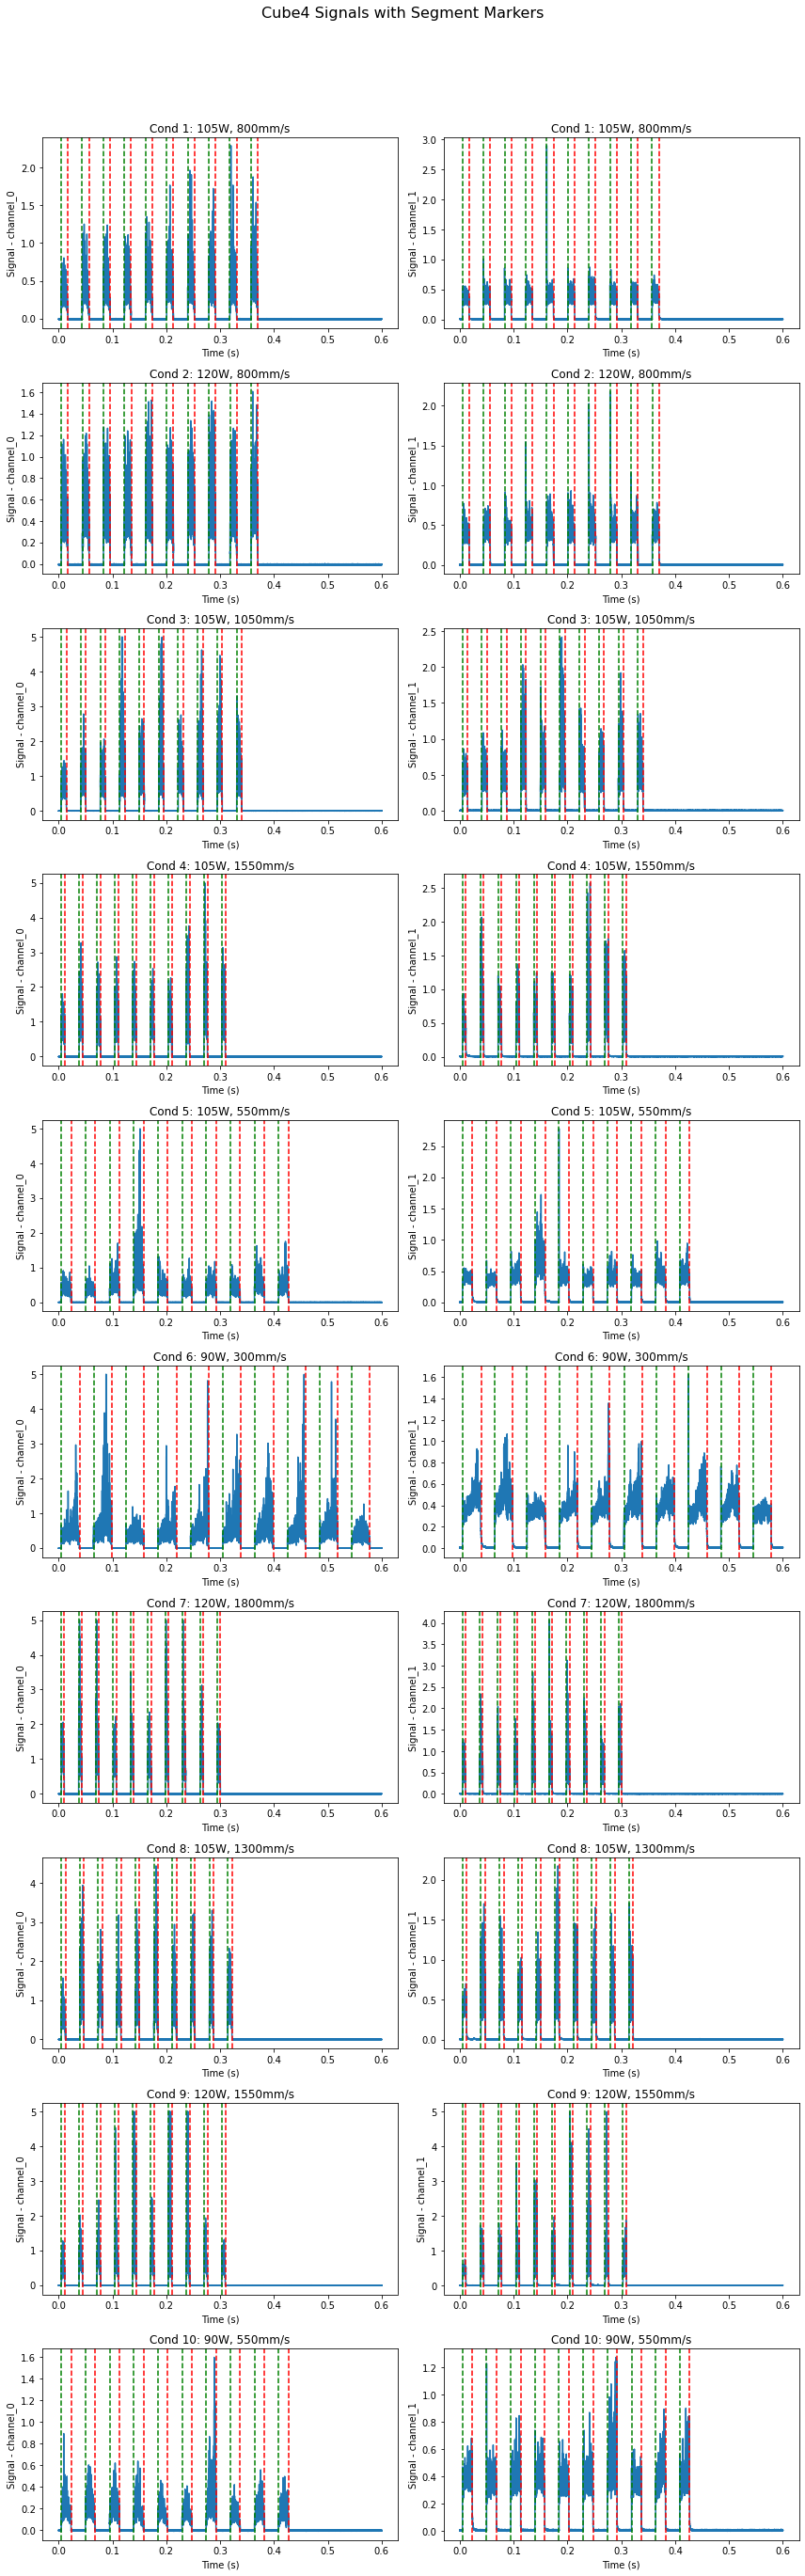

------------------------------
Working on cube 5
Condition 1: Found 10 segments, Avg. Size: 1533.20, Std. Dev: 9.43
Segment Max Size: 1538, Segment Min Size: 1505
Condition 2: Found 10 segments, Avg. Size: 1289.00, Std. Dev: 0.77
Segment Max Size: 1291, Segment Min Size: 1288
Condition 3: Found 10 segments, Avg. Size: 1110.20, Std. Dev: 1.08
Segment Max Size: 1112, Segment Min Size: 1108
Condition 4: Found 10 segments, Avg. Size: 6693.90, Std. Dev: 15.47
Segment Max Size: 6725, Segment Min Size: 6674
Condition 5: Found 11 segments, Avg. Size: 1262.18, Std. Dev: 94.32
Segment Max Size: 1317, Segment Min Size: 965
Condition 6: Found 11 segments, Avg. Size: 1290.18, Std. Dev: 0.72
Segment Max Size: 1292, Segment Min Size: 1289
Condition 7: Found 10 segments, Avg. Size: 1903.20, Std. Dev: 0.75
Segment Max Size: 1904, Segment Min Size: 1902
Condition 8: Found 10 segments, Avg. Size: 2500.30, Std. Dev: 3.49
Segment Max Size: 2507, Segment Min Size: 2498
Condition 9: Found 10 segments, Avg. S

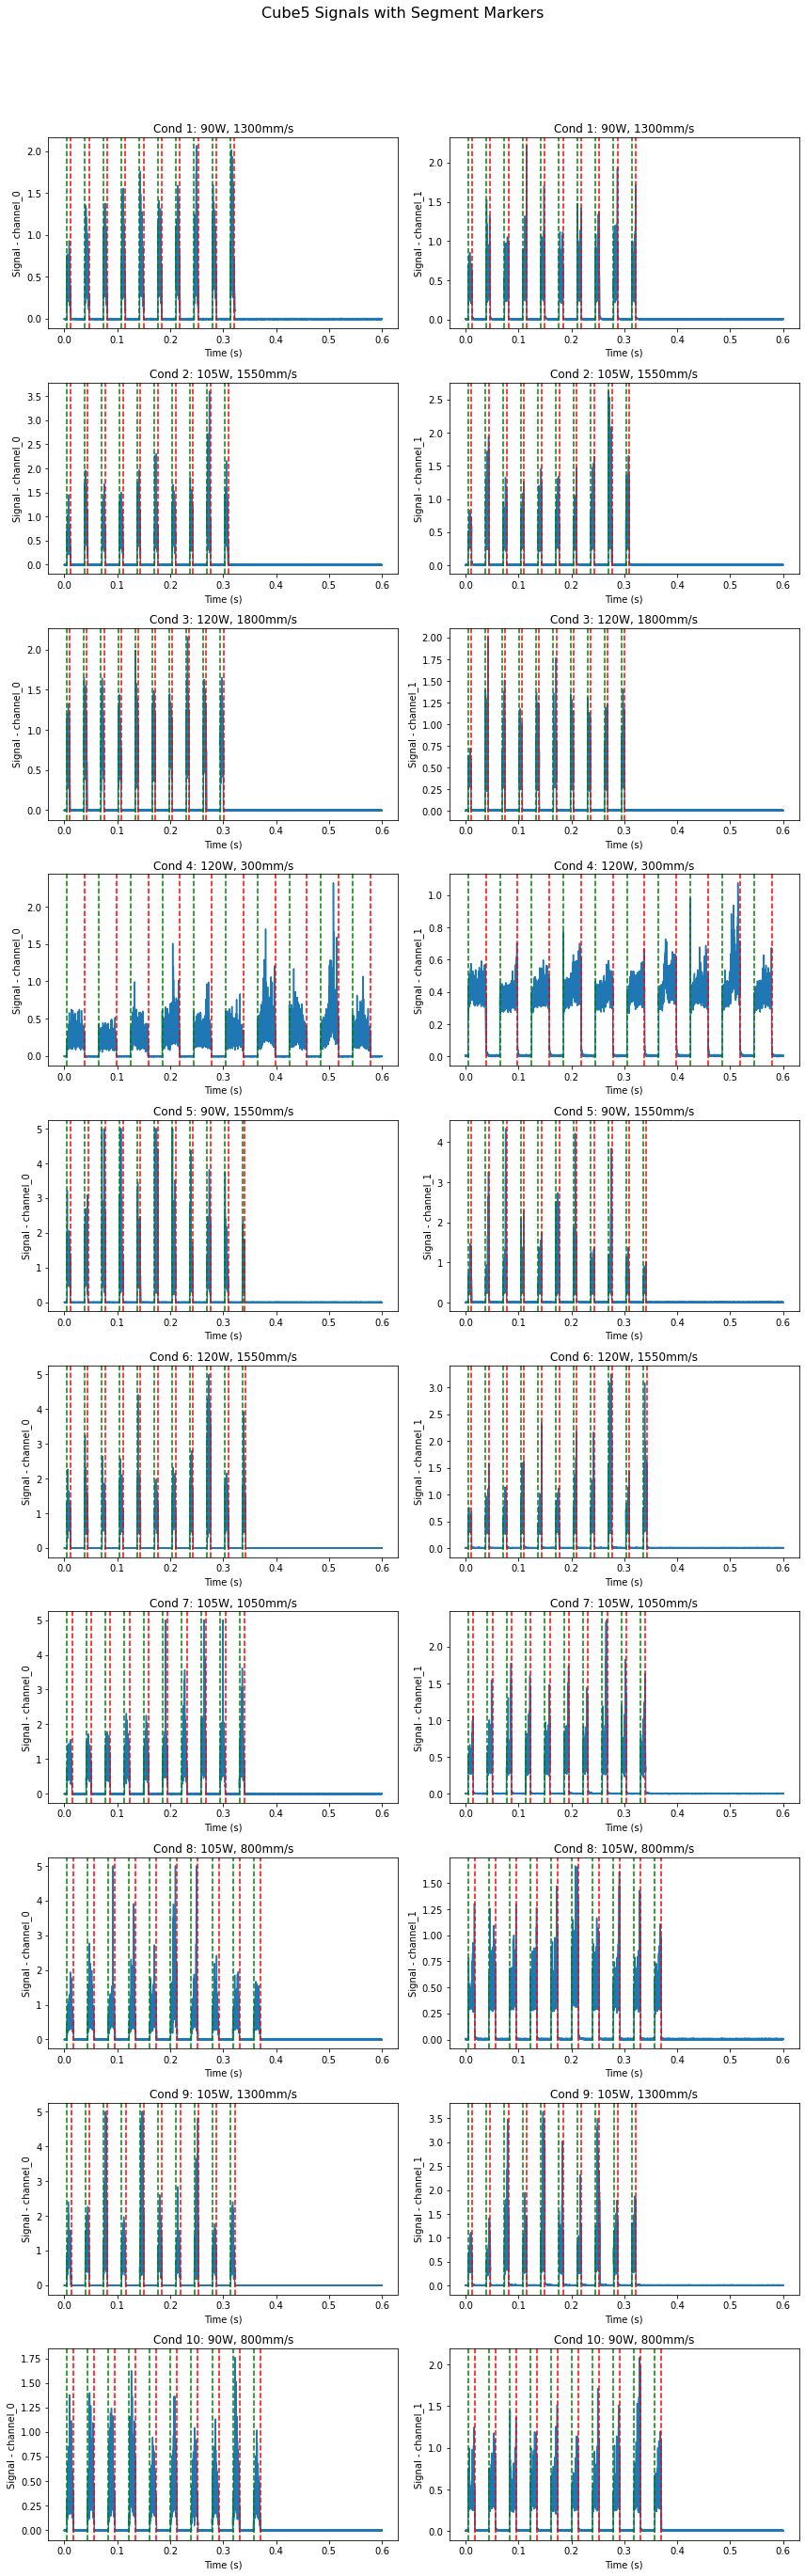

------------------------------
Working on cube 6
Condition 1: Found 10 segments, Avg. Size: 1539.50, Std. Dev: 13.71
Segment Max Size: 1565, Segment Min Size: 1507
Condition 2: Found 10 segments, Avg. Size: 3655.50, Std. Dev: 14.39
Segment Max Size: 3679, Segment Min Size: 3641
Condition 3: Found 10 segments, Avg. Size: 6724.50, Std. Dev: 38.44
Segment Max Size: 6772, Segment Min Size: 6674
Condition 4: Found 10 segments, Avg. Size: 2528.20, Std. Dev: 57.19
Segment Max Size: 2684, Segment Min Size: 2497
Condition 5: Found 10 segments, Avg. Size: 1903.70, Std. Dev: 3.44
Segment Max Size: 1911, Segment Min Size: 1899
Condition 6: Found 10 segments, Avg. Size: 3647.20, Std. Dev: 9.81
Segment Max Size: 3670, Segment Min Size: 3639
Condition 7: Found 10 segments, Avg. Size: 1110.60, Std. Dev: 2.24
Segment Max Size: 1117, Segment Min Size: 1109
Condition 8: Found 10 segments, Avg. Size: 6690.40, Std. Dev: 32.68
Segment Max Size: 6761, Segment Min Size: 6666
Condition 9: Found 10 segments, Av

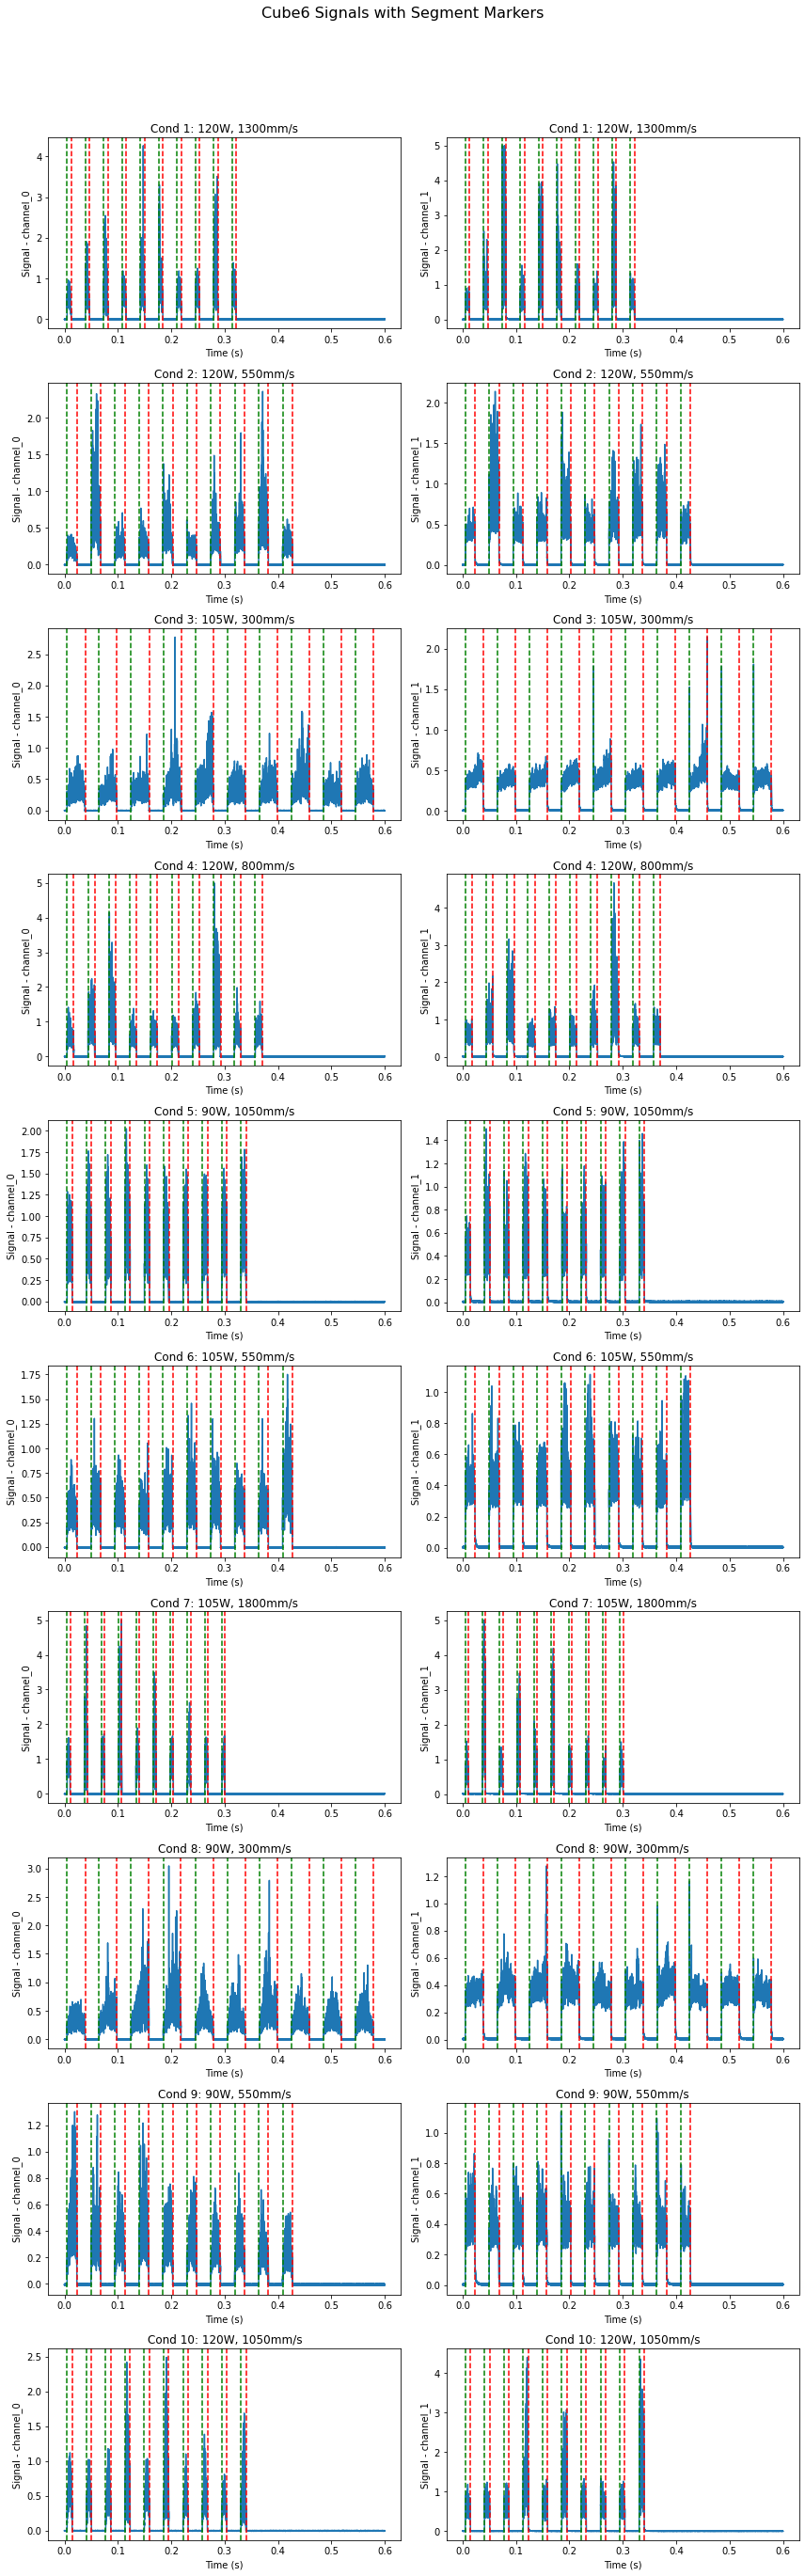

------------------------------
Working on cube 7
Condition 1: Found 10 segments, Avg. Size: 6713.90, Std. Dev: 38.66
Segment Max Size: 6785, Segment Min Size: 6674
Condition 2: Found 10 segments, Avg. Size: 1216.80, Std. Dev: 1.33
Segment Max Size: 1219, Segment Min Size: 1215
Condition 3: Found 10 segments, Avg. Size: 1349.10, Std. Dev: 5.37
Segment Max Size: 1363, Segment Min Size: 1344
Condition 4: Found 10 segments, Avg. Size: 5350.20, Std. Dev: 63.08
Segment Max Size: 5469, Segment Min Size: 5284
Condition 5: Found 10 segments, Avg. Size: 2148.50, Std. Dev: 9.91
Segment Max Size: 2178, Segment Min Size: 2143
Condition 6: Found 10 segments, Avg. Size: 2880.10, Std. Dev: 4.28
Segment Max Size: 2889, Segment Min Size: 2876
Condition 7: Found 10 segments, Avg. Size: 1713.50, Std. Dev: 3.56
Segment Max Size: 1723, Segment Min Size: 1711
Condition 8: Found 10 segments, Avg. Size: 3745.70, Std. Dev: 18.55
Segment Max Size: 3793, Segment Min Size: 3727
Condition 9: Found 10 segments, Avg.

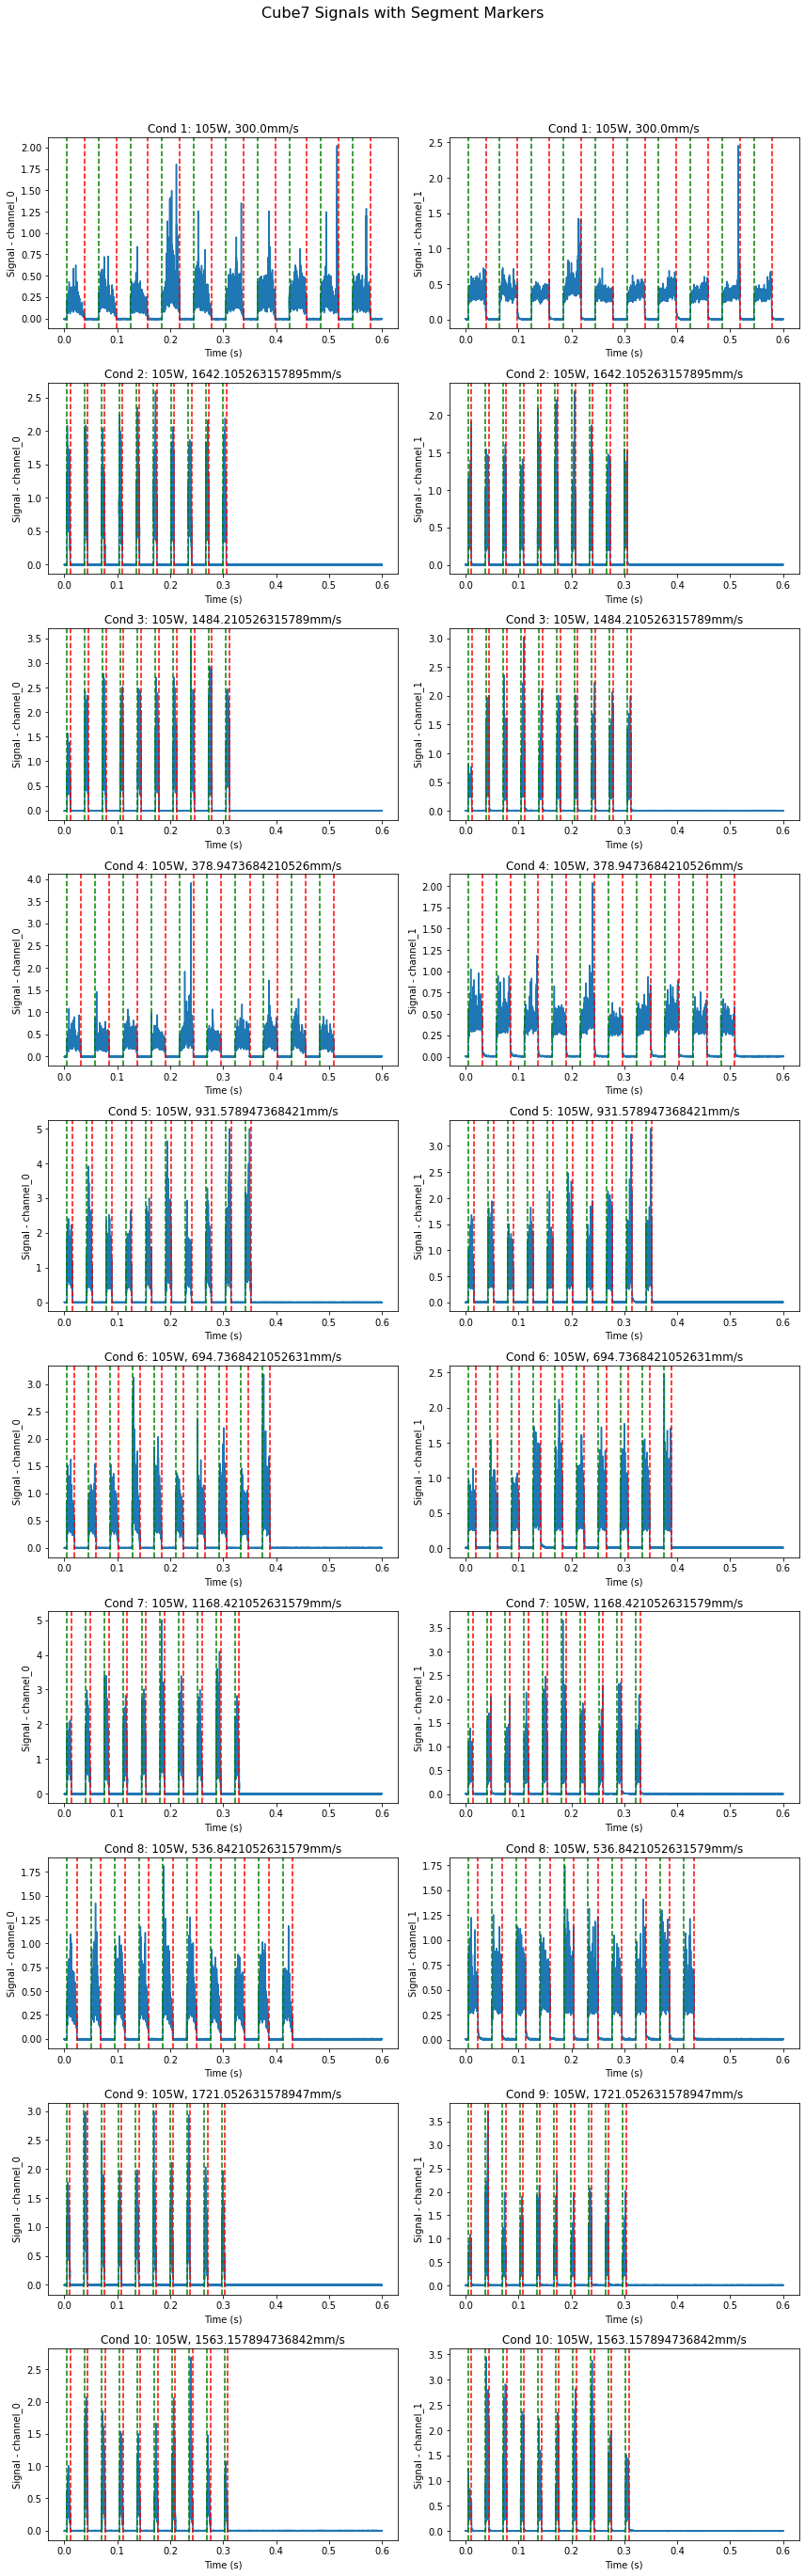

------------------------------
Working on cube 8
Condition 1: Found 11 segments, Avg. Size: 1462.64, Std. Dev: 153.46
Segment Max Size: 1533, Segment Min Size: 979
Condition 2: Found 11 segments, Avg. Size: 4398.00, Std. Dev: 28.43
Segment Max Size: 4457, Segment Min Size: 4369
Condition 3: Found 10 segments, Avg. Size: 1988.40, Std. Dev: 18.22
Segment Max Size: 2040, Segment Min Size: 1977
Condition 4: Found 11 segments, Avg. Size: 1077.55, Std. Dev: 109.98
Segment Max Size: 1121, Segment Min Size: 730
Condition 5: Found 11 segments, Avg. Size: 3235.64, Std. Dev: 102.89
Segment Max Size: 3332, Segment Min Size: 2924
Condition 6: Found 10 segments, Avg. Size: 1614.00, Std. Dev: 17.69
Segment Max Size: 1665, Segment Min Size: 1603
Condition 7: Found 10 segments, Avg. Size: 2350.40, Std. Dev: 9.99
Segment Max Size: 2379, Segment Min Size: 2345
Condition 8: Found 10 segments, Avg. Size: 1848.30, Std. Dev: 14.57
Segment Max Size: 1876, Segment Min Size: 1836
Condition 9: Found 11 segments,

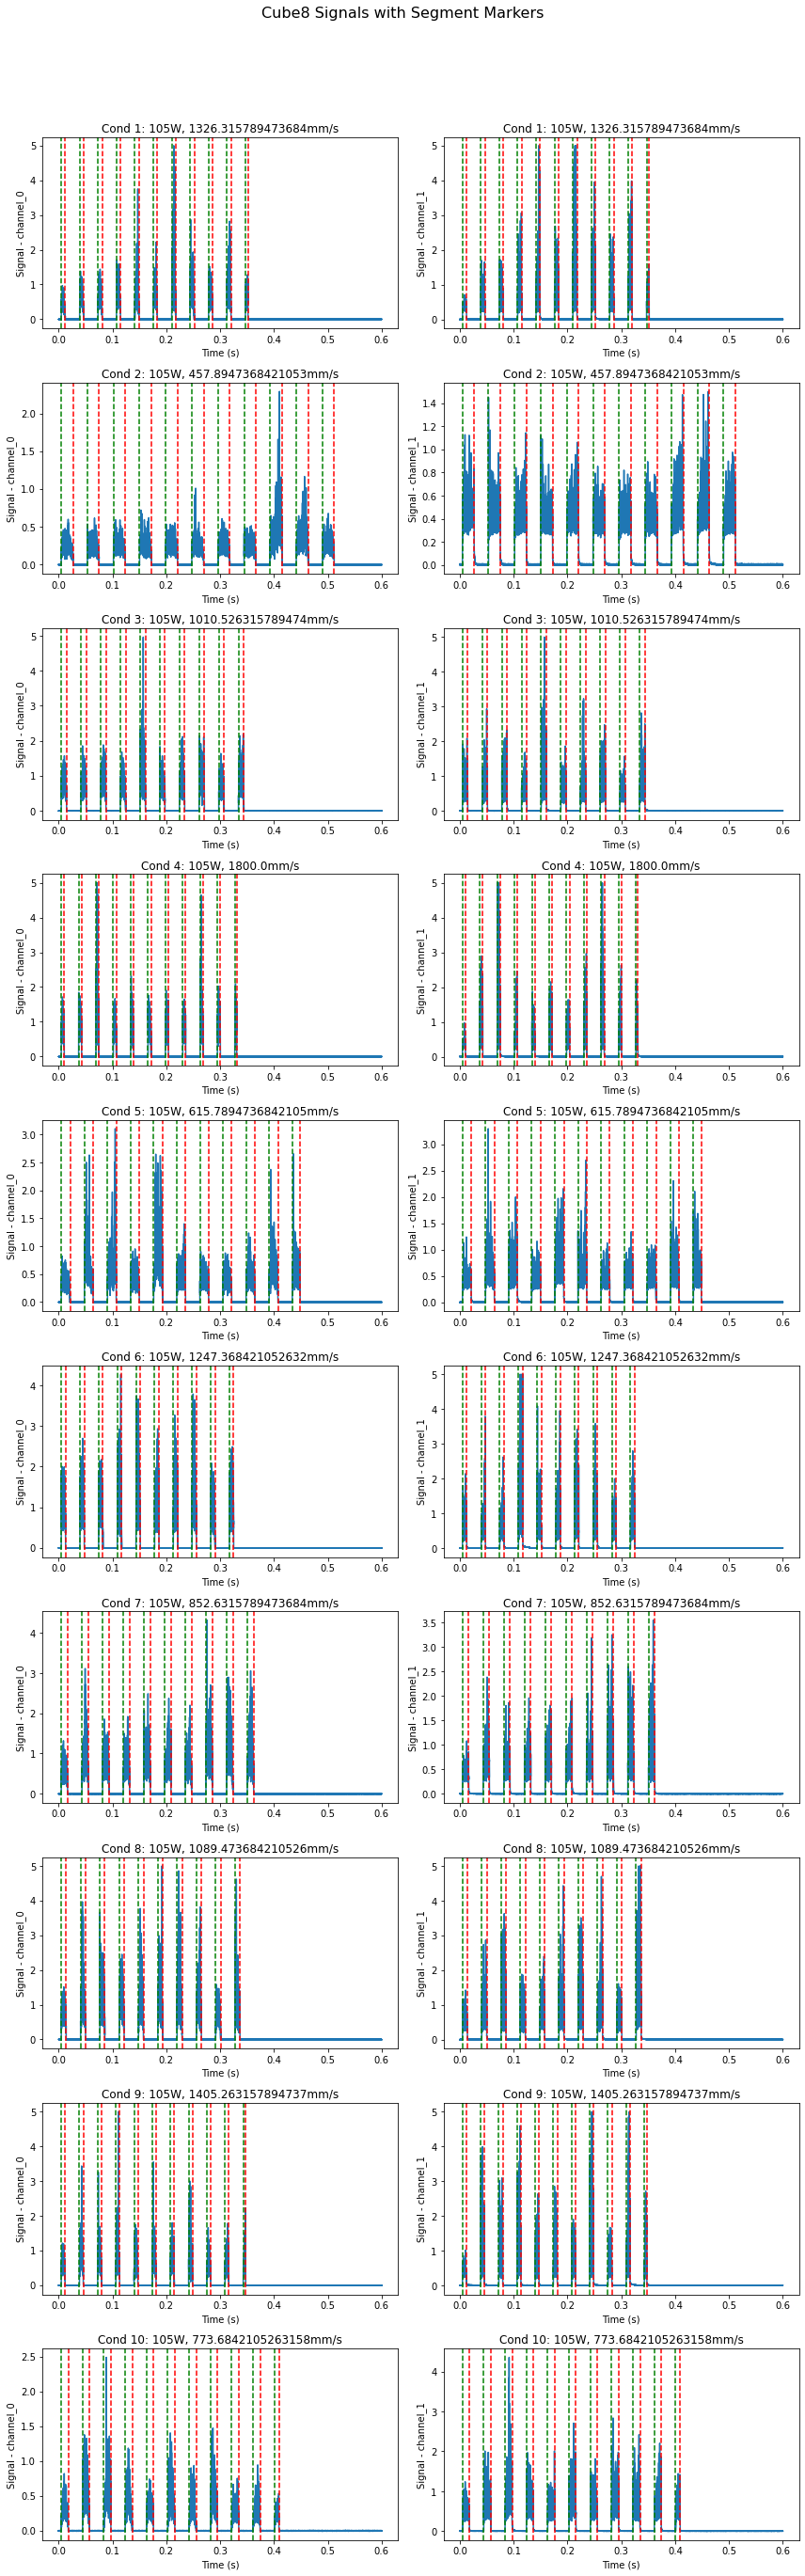

------------------------------
Working on cube 9
Condition 1: Found 10 segments, Avg. Size: 1906.70, Std. Dev: 7.81
Segment Max Size: 1922, Segment Min Size: 1890
Condition 2: Found 10 segments, Avg. Size: 2515.40, Std. Dev: 31.85
Segment Max Size: 2607, Segment Min Size: 2496
Condition 3: Found 10 segments, Avg. Size: 1116.20, Std. Dev: 4.09
Segment Max Size: 1123, Segment Min Size: 1110
Condition 4: Found 10 segments, Avg. Size: 1554.60, Std. Dev: 22.94
Segment Max Size: 1607, Segment Min Size: 1537
Condition 5: Found 10 segments, Avg. Size: 3664.30, Std. Dev: 32.52
Segment Max Size: 3746, Segment Min Size: 3639
Condition 6: Found 10 segments, Avg. Size: 2505.20, Std. Dev: 3.82
Segment Max Size: 2512, Segment Min Size: 2500
Condition 7: Found 10 segments, Avg. Size: 1546.90, Std. Dev: 8.32
Segment Max Size: 1562, Segment Min Size: 1537
Condition 8: Found 10 segments, Avg. Size: 1936.80, Std. Dev: 47.06
Segment Max Size: 2053, Segment Min Size: 1906
Condition 9: Found 10 segments, Avg

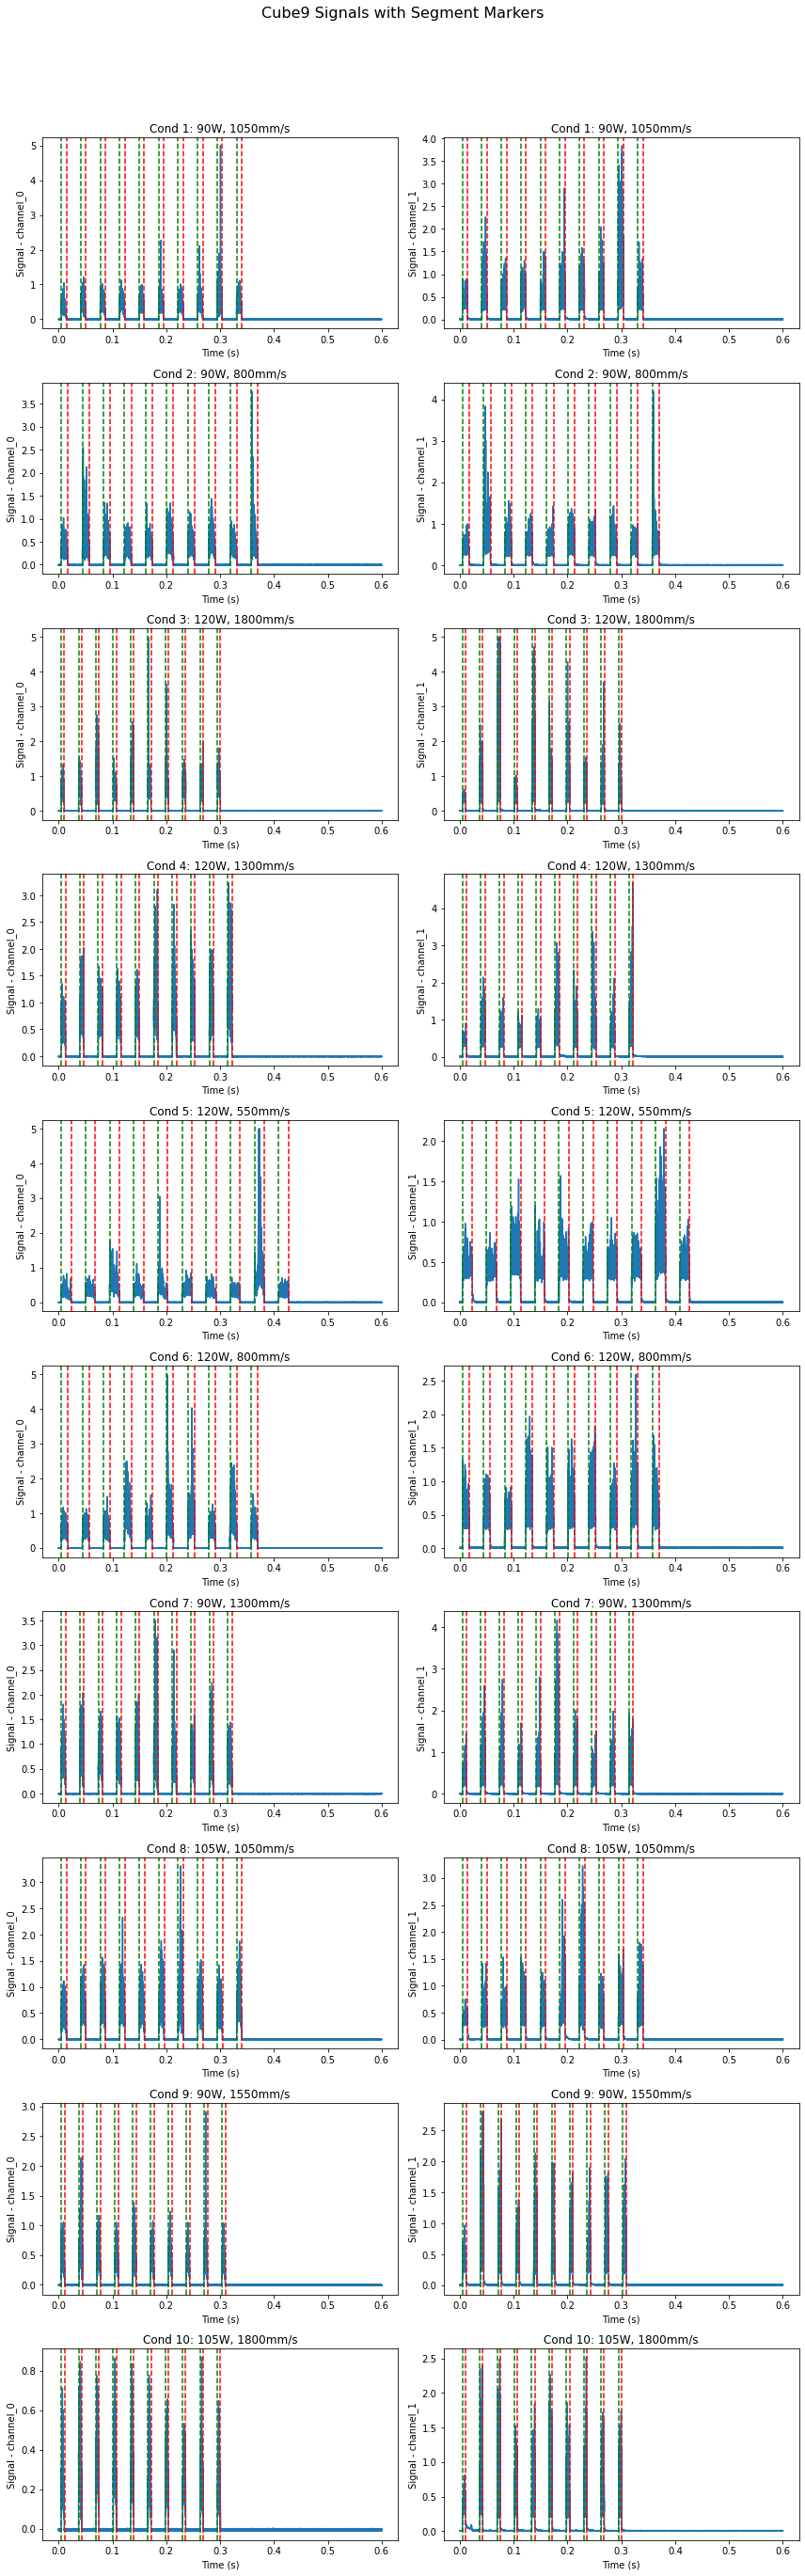

------------------------------


In [5]:
for cube_number in range(1, 10):
    print(f'Working on cube {cube_number}')
    plot_and_segment_cube_signals(cube_number, threshold=0.1)  
    print('---'*10)

In [6]:
segmented_data_dict

{(90,
  1050,
  1): array([[[ 0.1974487 ,  0.2879333 ,  0.471344  , ..., -0.00259399,
          -0.00823975, -0.00183106],
         [ 0.1138306 ,  0.2400208 ,  0.39505   , ...,  0.1063538 ,
           0.1017761 ,  0.1010132 ]],
 
        [[ 0.1771545 ,  0.2001953 ,  0.1760864 , ...,  0.00900269,
           0.0100708 ,  0.00701904],
         [ 0.1116943 ,  0.1506042 ,  0.1829529 , ...,  0.198822  ,
           0.1898193 ,  0.1795959 ]],
 
        [[ 0.2210999 ,  0.3642273 ,  0.2722168 , ...,  0.01052856,
           0.0088501 ,  0.01098633],
         [ 0.2210999 ,  0.471344  ,  0.5839539 , ...,  0.176239  ,
           0.1678467 ,  0.1568604 ]],
 
        ...,
 
        [[ 0.1092529 ,  0.6085205 ,  0.3352356 , ...,  0.01419067,
           0.0100708 ,  0.01251221],
         [ 0.1635742 ,  0.2845764 ,  0.3594971 , ...,  0.1849365 ,
           0.1745605 ,  0.165863  ]],
 
        [[ 0.6001282 ,  0.6665039 ,  0.5734253 , ...,  0.00854492,
           0.00427246,  0.00610352],
         [ 0.19653

In [7]:
def print_segmented_data_summary(segmented_data_dict):
    print("Summary of Segmented Data:")
    for key, tensor in segmented_data_dict.items():
        power, speed, cube_number = key
        print(f"Cube {cube_number}, Power: {power}W, Speed: {speed}mm/s - Tensor Size: {tensor.shape}")

# Call the summary function
print_segmented_data_summary(segmented_data_dict)


Summary of Segmented Data:
Cube 1, Power: 90W, Speed: 1050mm/s - Tensor Size: (10, 2, 2213)
Cube 1, Power: 90W, Speed: 800mm/s - Tensor Size: (10, 2, 2795)
Cube 1, Power: 120W, Speed: 1800mm/s - Tensor Size: (10, 2, 1407)
Cube 1, Power: 120W, Speed: 1300mm/s - Tensor Size: (10, 2, 1835)
Cube 1, Power: 120W, Speed: 550mm/s - Tensor Size: (10, 2, 3636)
Cube 1, Power: 120W, Speed: 800mm/s - Tensor Size: (10, 2, 2498)
Cube 1, Power: 90W, Speed: 1300mm/s - Tensor Size: (10, 2, 1535)
Cube 1, Power: 105W, Speed: 1050mm/s - Tensor Size: (10, 2, 1902)
Cube 1, Power: 90W, Speed: 1550mm/s - Tensor Size: (10, 2, 1286)
Cube 1, Power: 105W, Speed: 1800mm/s - Tensor Size: (10, 2, 1106)
Cube 2, Power: 105W, Speed: 800mm/s - Tensor Size: (11, 2, 2469)
Cube 2, Power: 120W, Speed: 300mm/s - Tensor Size: (10, 2, 6671)
Cube 2, Power: 105W, Speed: 1300mm/s - Tensor Size: (10, 2, 1535)
Cube 2, Power: 120W, Speed: 1050mm/s - Tensor Size: (10, 2, 1902)
Cube 2, Power: 105W, Speed: 300mm/s - Tensor Size: (10, 2,

In [8]:
import pickle

# Define the path where you want to save the dictionary
pickle_file_path = base_path + '/segmented_data_dict.pkl'

# Save the dictionary
with open(pickle_file_path, 'wb') as file:
    pickle.dump(segmented_data_dict, file)

print(f'Saved segmented_data_dict to {pickle_file_path}')


Saved segmented_data_dict to ./Data/Neuchatel_316L/segmented_data_dict.pkl


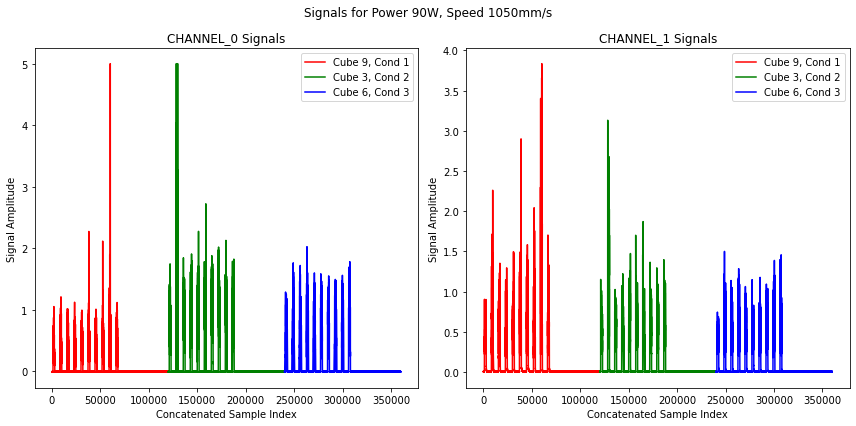

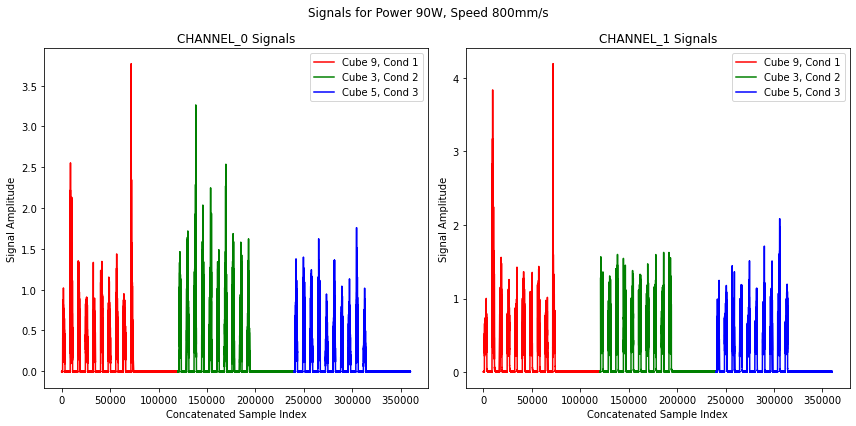

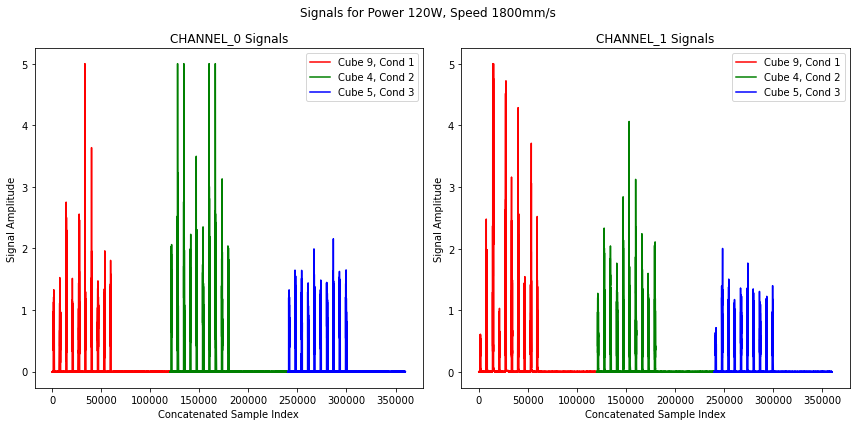

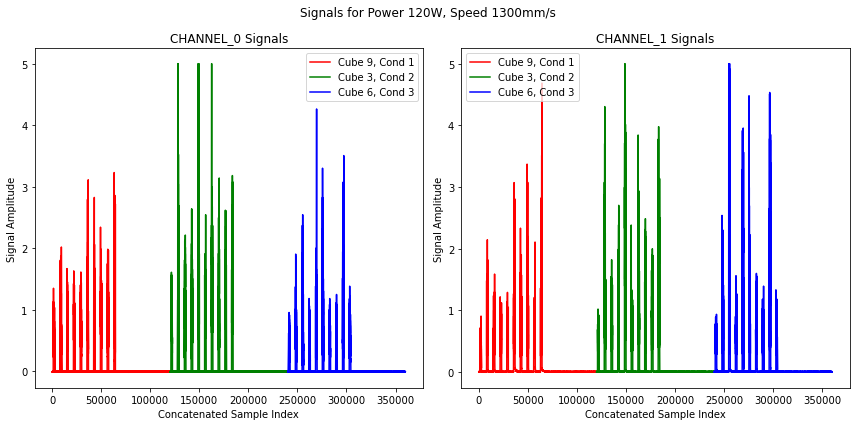

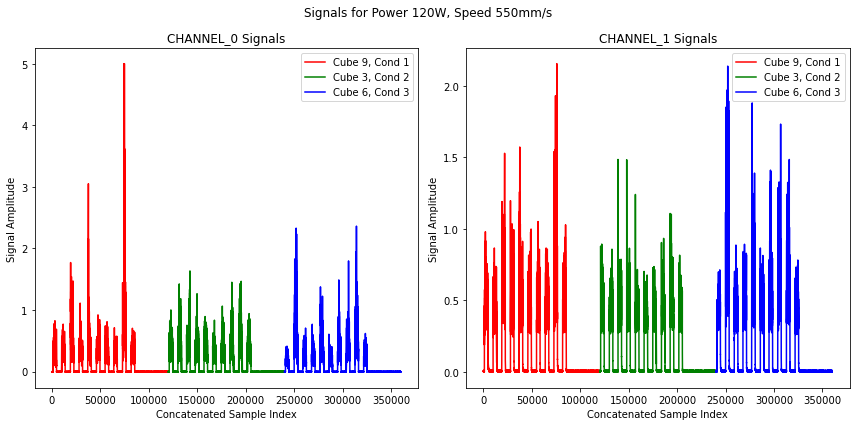

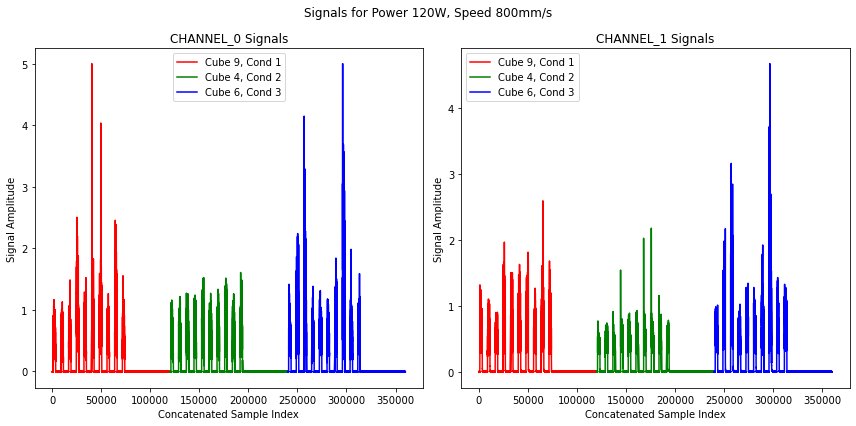

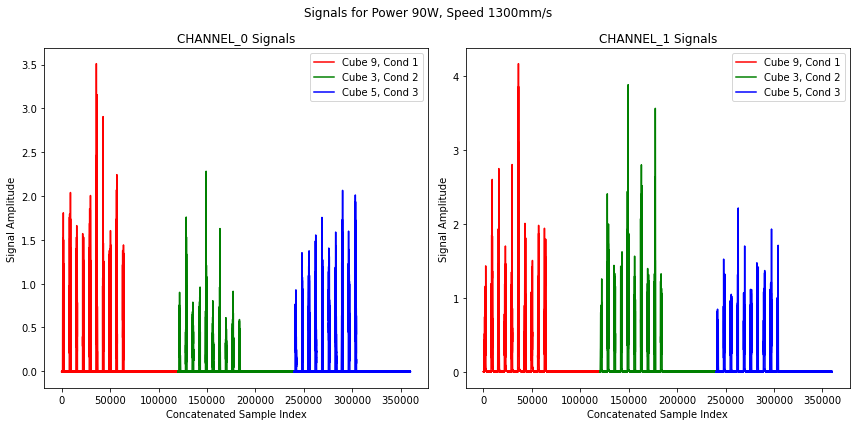

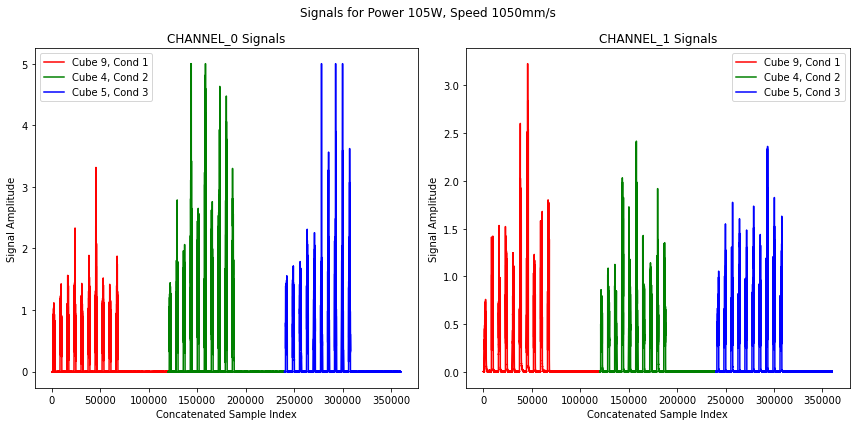

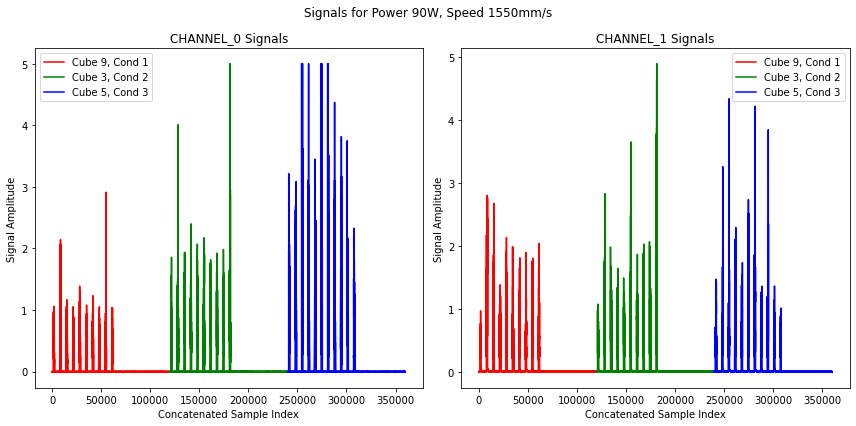

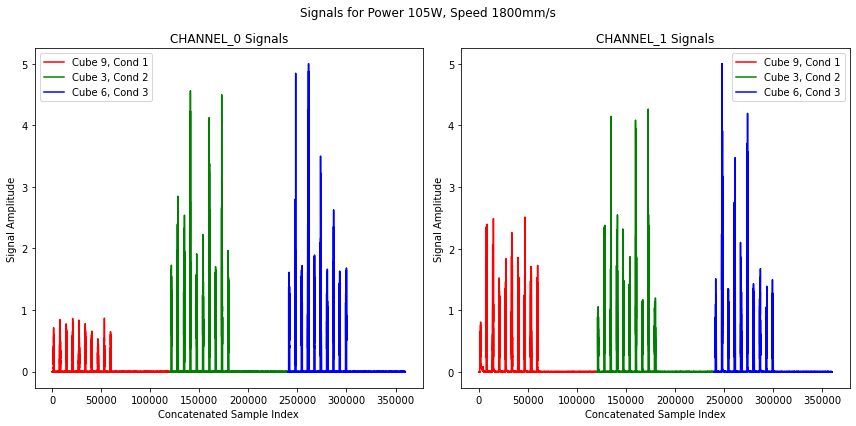

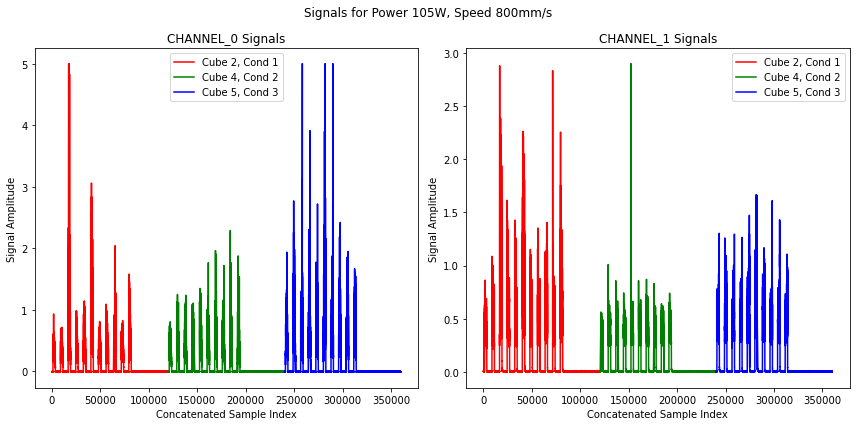

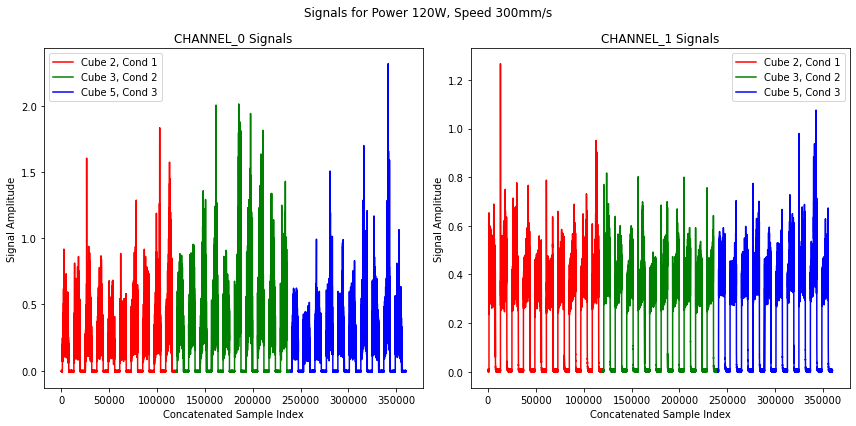

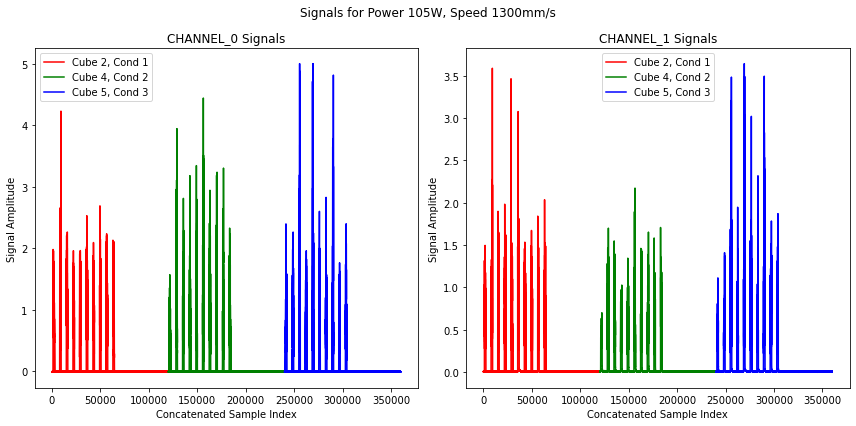

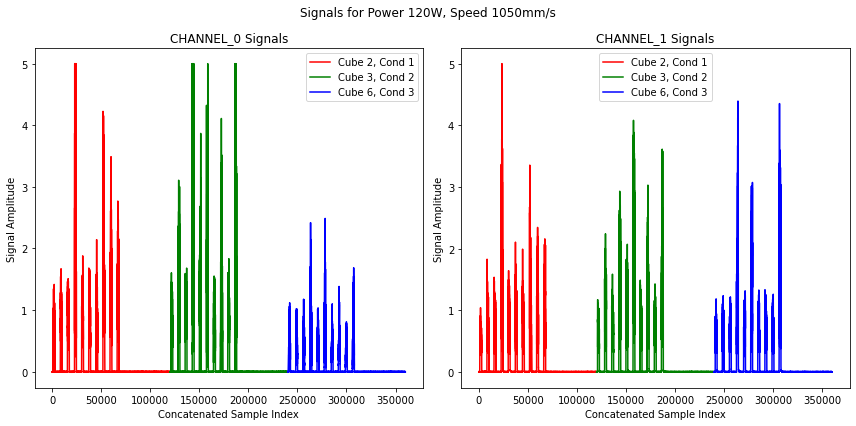

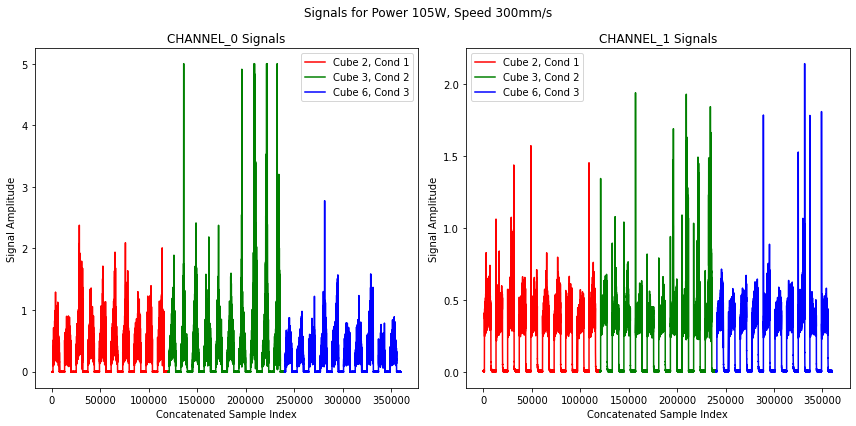

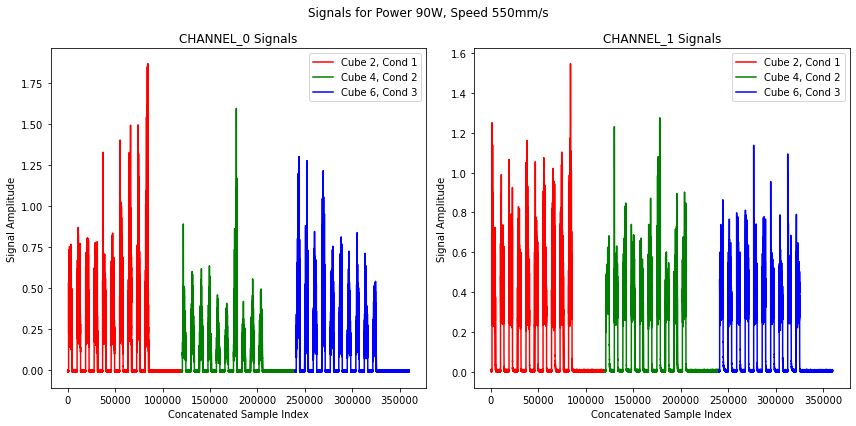

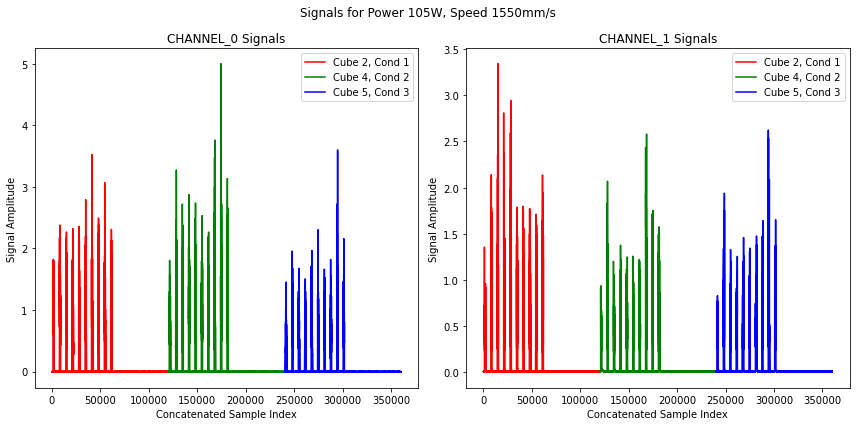

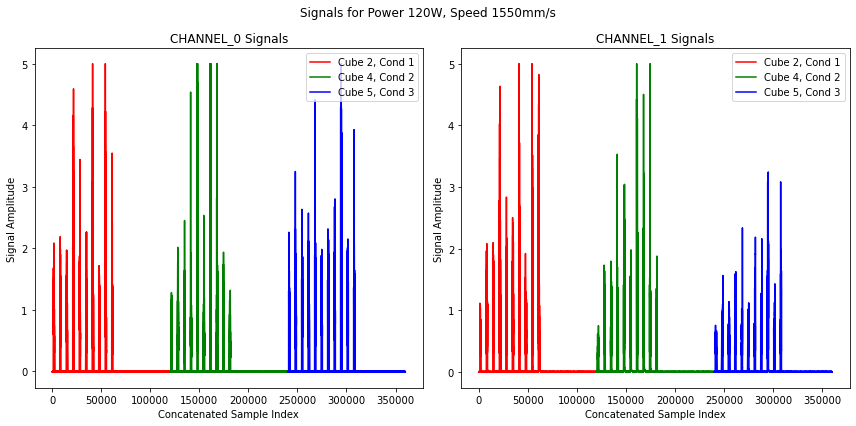

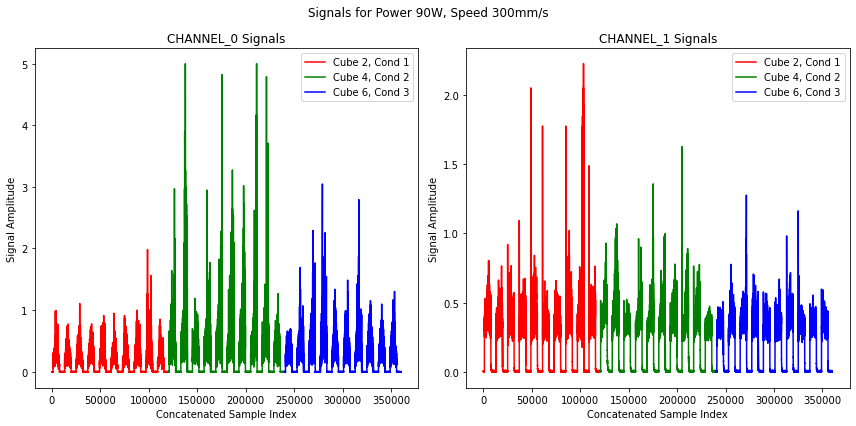

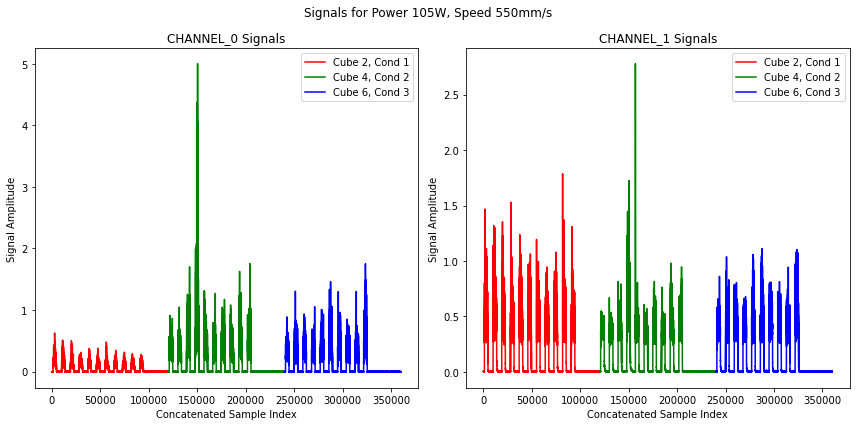

In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_concatenated_signals_by_parameters(cubes_list, base_path, params_dict):
    concatenated_signals = {}
    signal_sources = {}

    for cube in cubes_list:
        cube_name = f'Cube{cube}'
        cube_path = os.path.join(base_path, cube_name)
        
        for condition in range(10):  # Assuming 10 conditions per cube
            data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{condition}.csv')).to_numpy().flatten()
            data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{condition}.csv')).to_numpy().flatten()
            
            param_set = params_dict[cube_name][condition]
            key = (param_set['Power (W)'], param_set['Speed (mm/s)'])
            
            if key not in concatenated_signals:
                concatenated_signals[key] = {'channel_0': np.array([]), 'channel_1': np.array([])}
                signal_sources[key] = {'channel_0': [], 'channel_1': []}
            
            concatenated_signals[key]['channel_0'] = np.concatenate((concatenated_signals[key]['channel_0'], data_channel_0))
            concatenated_signals[key]['channel_1'] = np.concatenate((concatenated_signals[key]['channel_1'], data_channel_1))
            signal_sources[key]['channel_0'].append(cube)
            signal_sources[key]['channel_1'].append(cube)

    # Generate a set of unique colors for plotting
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'grey']

    # Plotting
    for params, channels_data in concatenated_signals.items():
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle(f'Signals for Power {params[0]}W, Speed {params[1]}mm/s')
        
        for i, channel in enumerate(['channel_0', 'channel_1']):
            ax = axes[i]
            offset = 0  # Offset to keep track of where to start plotting the next cube's signal
            for cube_index, signal_data in enumerate(signal_sources[params][channel]):
                cube_length = len(channels_data[channel]) // len(signal_sources[params][channel])  # Estimate length per cube
                # Use a different color for each cube
                color = colors[cube_index % len(colors)]
                label = f'Cube {signal_data}, Cond {cube_index + 1}'
                ax.plot(range(offset, offset + cube_length), channels_data[channel][offset:offset + cube_length], label=label, color=color)
                offset += cube_length
            ax.set_title(f'{channel.upper()} Signals')
            ax.set_xlabel('Concatenated Sample Index')
            ax.set_ylabel('Signal Amplitude')
            ax.legend()
        
        plt.tight_layout()
        plt.show()

cubes_list = [9,2,3,4,5,6]  
plot_concatenated_signals_by_parameters(cubes_list, base_path, params_dict)


In [10]:
def segment_and_organize_signals(cubes_list, base_path, params_dict, threshold):
    # Initialize a dictionary to store the tensors for each parameter set
    segmented_data = {}

    for cube in cubes_list:
        cube_name = f'Cube{cube}'
        cube_path = os.path.join(base_path, cube_name)
        
        for condition in range(10):  # 10 conditions per cube
            # Load channel data
            data_channel_0 = pd.read_csv(os.path.join(cube_path, 'channel_0', f'File_{condition}.csv')).to_numpy().flatten()
            data_channel_1 = pd.read_csv(os.path.join(cube_path, 'channel_1', f'File_{condition}.csv')).to_numpy().flatten()
            
            # Segment channel 1
            starting_1, ending_1 = computeBoundaries(data_channel_1, threshold)
            
            # Determine the length of the shortest segment
            segment_lengths = [end - start for start, end in zip(starting_1, ending_1)]
            min_length = min(segment_lengths)
            
            # Extract the parameter set for this condition
            param_set = params_dict[cube_name][condition]
            key = (param_set['Power (W)'], param_set['Speed (mm/s)'])
            
            if key not in segmented_data:
                segmented_data[key] = []

            # Segment and store data for both channels using the boundaries found in channel 1
            for start, end in zip(starting_1, ending_1):
                segment = np.zeros((2, min_length))
                segment[0, :] = data_channel_0[start:start+min_length]
                segment[1, :] = data_channel_1[start:start+min_length]
                segmented_data[key].append(segment)
    
    # Convert lists to tensors and adjust to have uniform shape (N, 2, M)
    for key, segments in segmented_data.items():
        total_segments = len(segments)
        if total_segments == 0:
            continue
        min_segment_length = min(segment.shape[1] for segment in segments)
        tensor_shape = (total_segments, 2, min_segment_length)
        tensor = np.zeros(tensor_shape)
        for i, segment in enumerate(segments):
            tensor[i, :, :] = segment[:, :min_segment_length]
        segmented_data[key] = tensor

    return segmented_data


In [37]:
cubes_list = [9,2,3,4, 5,6]
segmented_data = segment_and_organize_signals(cubes_list, base_path, params_dict, threshold=0.1)

In [38]:
def print_segmented_data_summary(segmented_data_dict):
    print("Summary of Segmented Data:")
    for key, tensor in segmented_data_dict.items():
        power, speed = key
        print(f"Power: {power}W, Speed: {speed}mm/s - Tensor Size: {tensor.shape}")

# Call the summary function
print_segmented_data_summary(segmented_data)


Summary of Segmented Data:
Power: 90W, Speed: 1050mm/s - Tensor Size: (30, 2, 1890)
Power: 90W, Speed: 800mm/s - Tensor Size: (30, 2, 2495)
Power: 120W, Speed: 1800mm/s - Tensor Size: (30, 2, 1108)
Power: 120W, Speed: 1300mm/s - Tensor Size: (30, 2, 1507)
Power: 120W, Speed: 550mm/s - Tensor Size: (30, 2, 3635)
Power: 120W, Speed: 800mm/s - Tensor Size: (30, 2, 2497)
Power: 90W, Speed: 1300mm/s - Tensor Size: (30, 2, 1505)
Power: 105W, Speed: 1050mm/s - Tensor Size: (30, 2, 1902)
Power: 90W, Speed: 1550mm/s - Tensor Size: (31, 2, 965)
Power: 105W, Speed: 1800mm/s - Tensor Size: (30, 2, 1108)
Power: 105W, Speed: 800mm/s - Tensor Size: (31, 2, 2467)
Power: 120W, Speed: 300mm/s - Tensor Size: (30, 2, 6671)
Power: 105W, Speed: 1300mm/s - Tensor Size: (30, 2, 1535)
Power: 120W, Speed: 1050mm/s - Tensor Size: (30, 2, 1902)
Power: 105W, Speed: 300mm/s - Tensor Size: (30, 2, 6665)
Power: 90W, Speed: 550mm/s - Tensor Size: (30, 2, 3633)
Power: 105W, Speed: 1550mm/s - Tensor Size: (30, 2, 1287)


In [39]:
def plot_concatenated_segments(segmented_data):
    for (power, speed), tensor in segmented_data.items():
        # Determine the number of segments (N) and the length of the shortest segment (M)
        N, _, M = tensor.shape

        fig, axes = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle(f'Concatenated Segments for Power {power}W, Speed {speed}mm/s', fontsize=16)
        
        # Reduce the tensor to (1, 2, M) using the median across the first axis
        median_tensor = np.mean(tensor[:,:,int(tensor.shape[-1]*0.1):int(tensor.shape[-1]*0.9)], axis=0, keepdims=True)

        # Concatenate segments for plotting
        for channel in range(2):
            concatenated_segments = np.concatenate([tensor[i, channel, :] for i in range(N)], axis=0)
            ax = axes[channel]
            ax.plot(concatenated_segments, label=f'Channel {channel} Concatenated Segments')
            ax.plot(median_tensor[:, channel, :].flatten(), label=f'Channel {channel} median Segments') # repeat this N times

            ax.set_title(f'Channel {channel}')
            ax.set_xlabel('Concatenated Sample Index')
            ax.set_ylabel('Signal Amplitude')
            ax.legend()
        

        plt.tight_layout()
        plt.show()


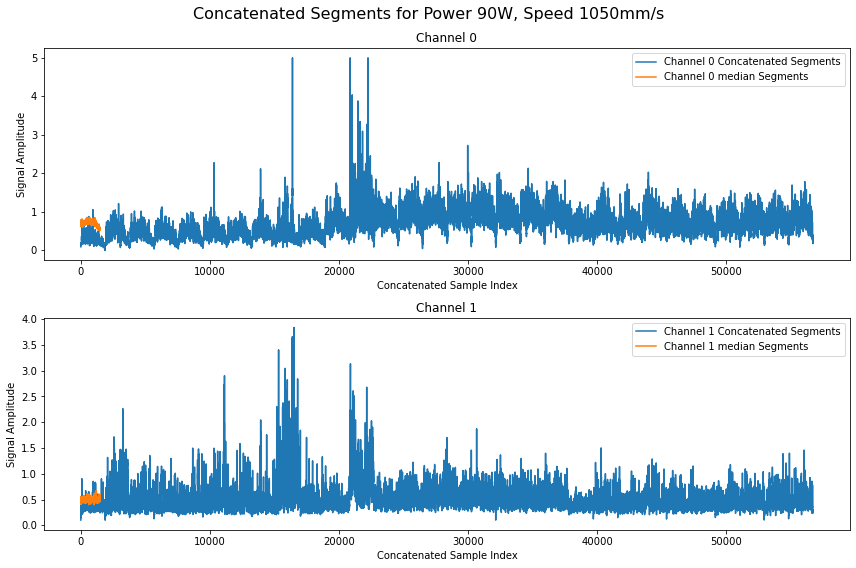

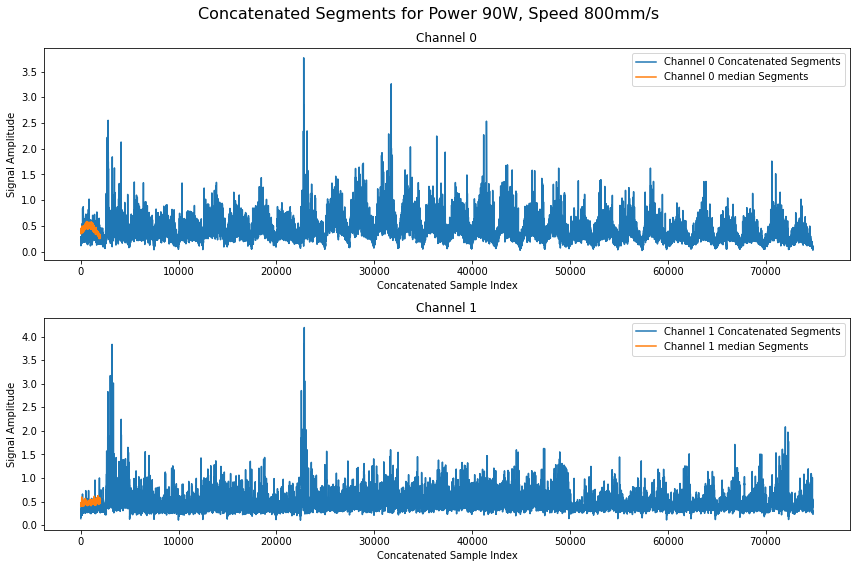

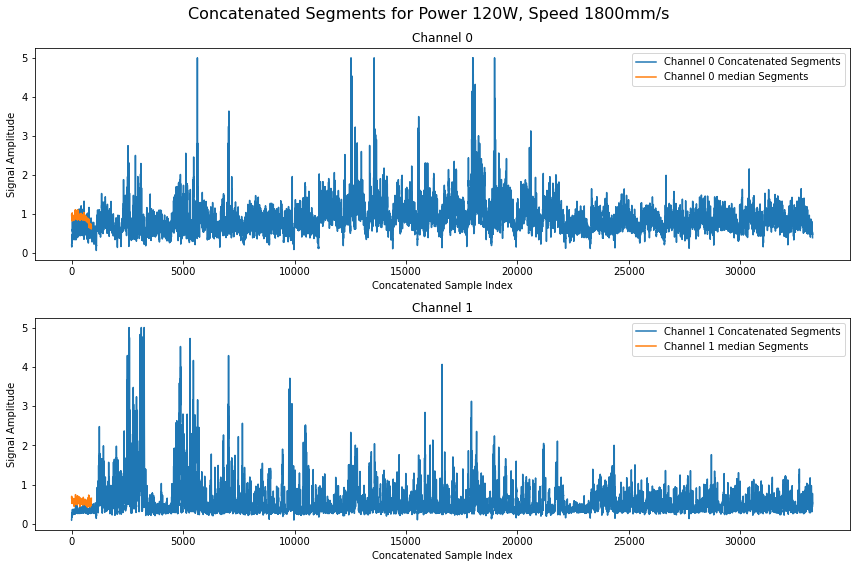

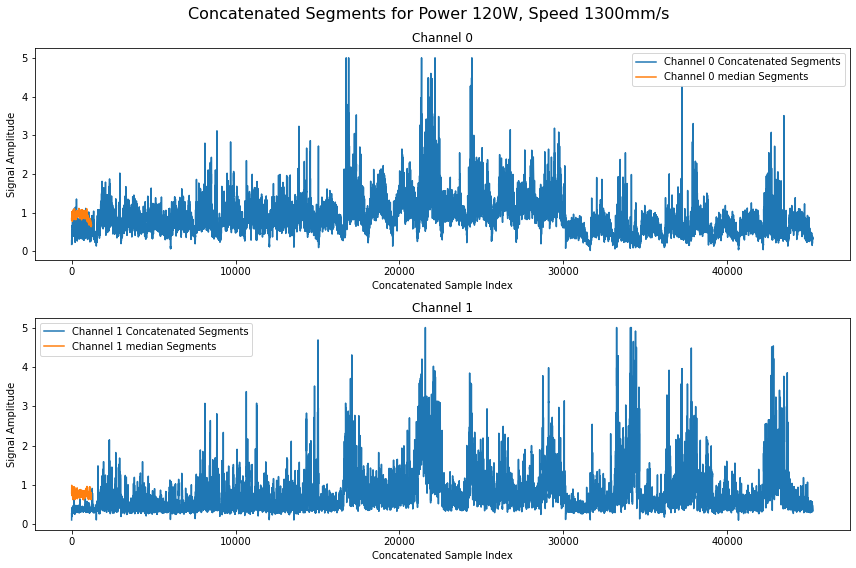

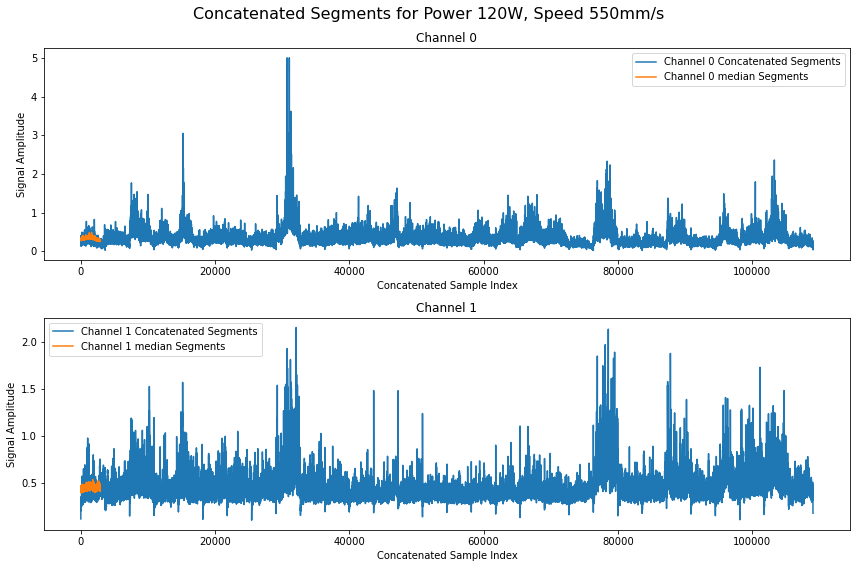

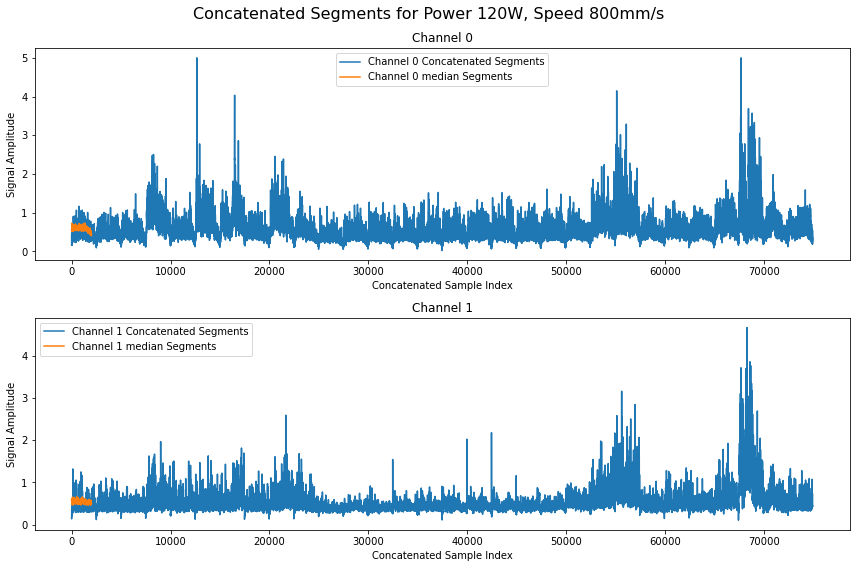

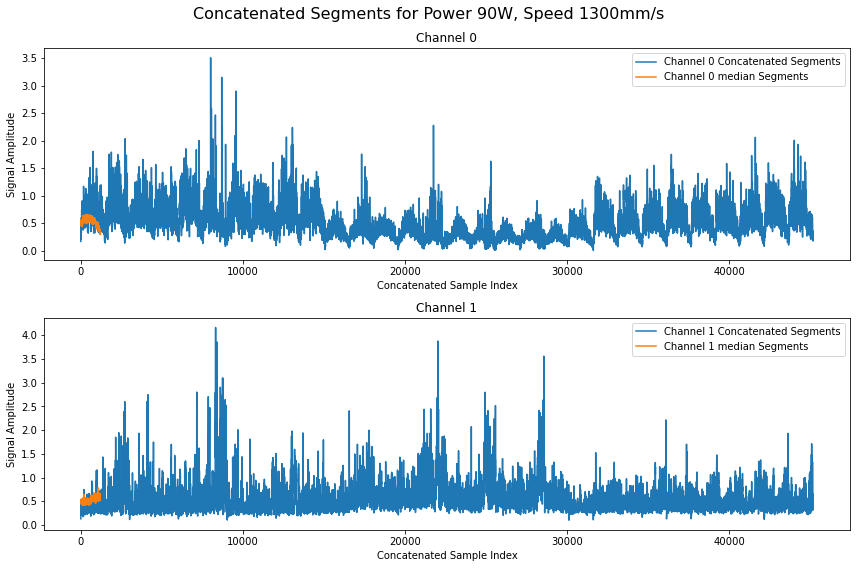

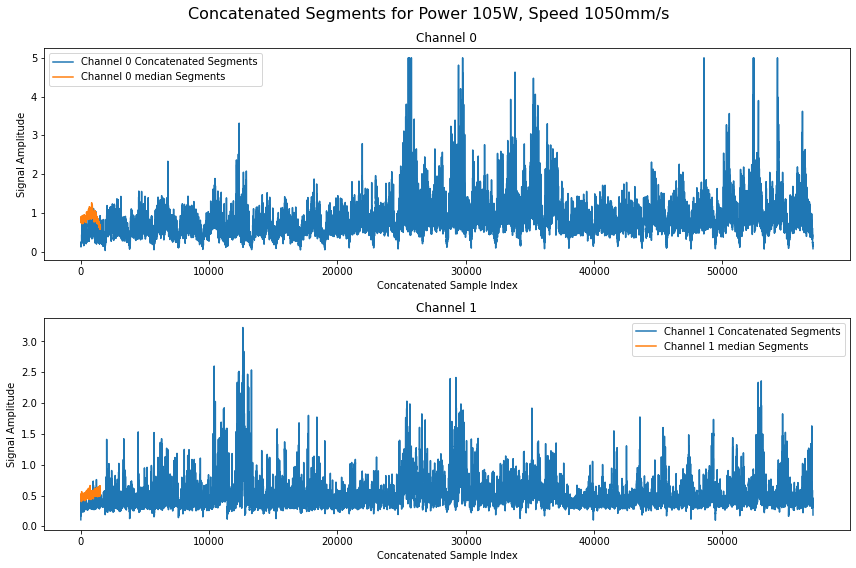

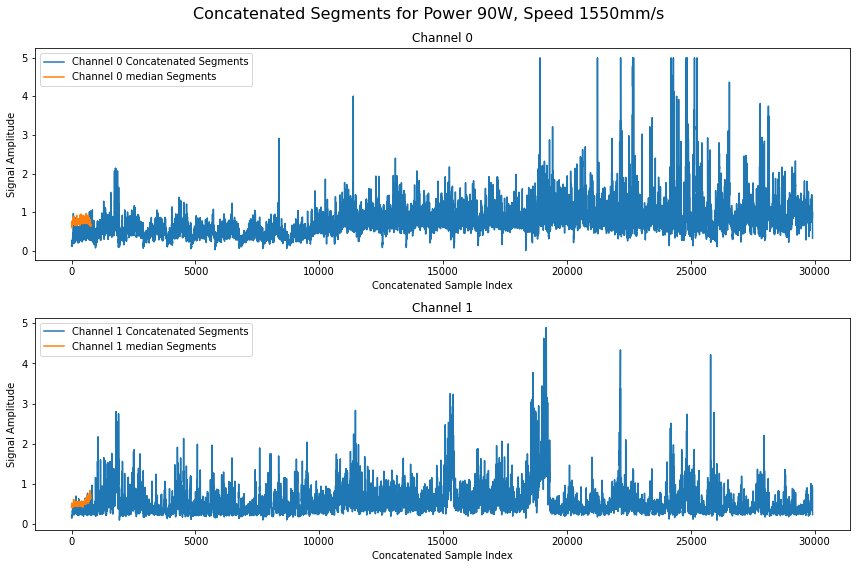

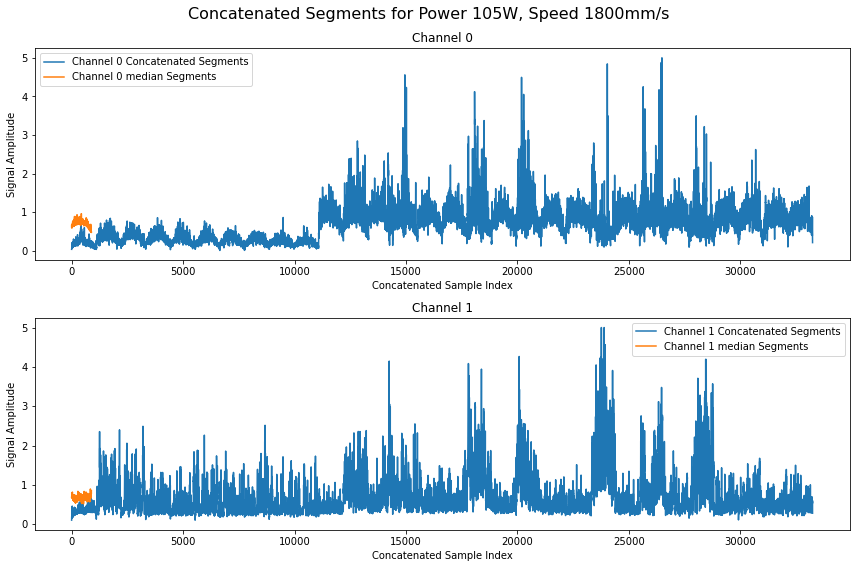

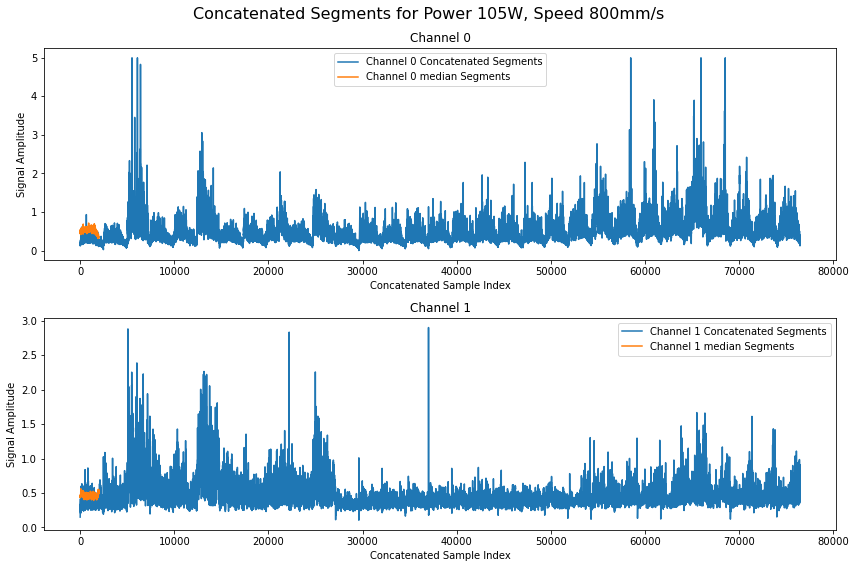

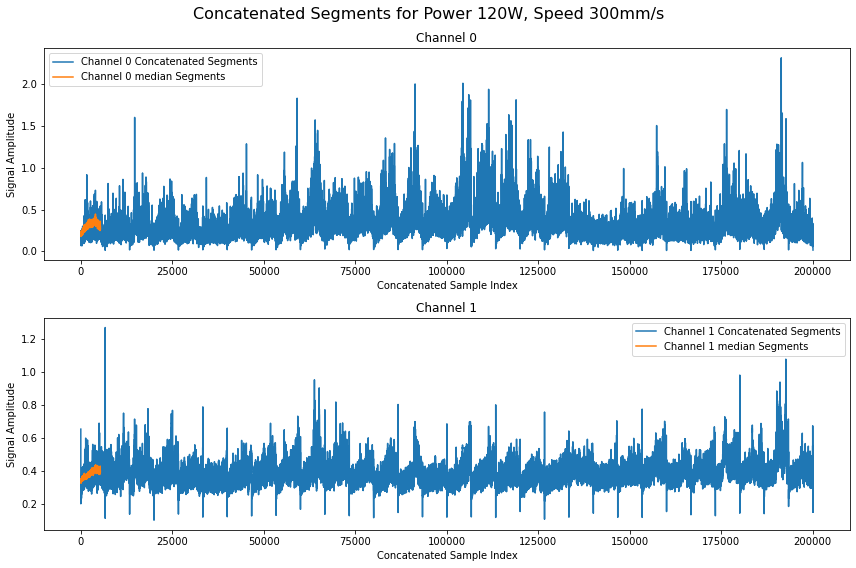

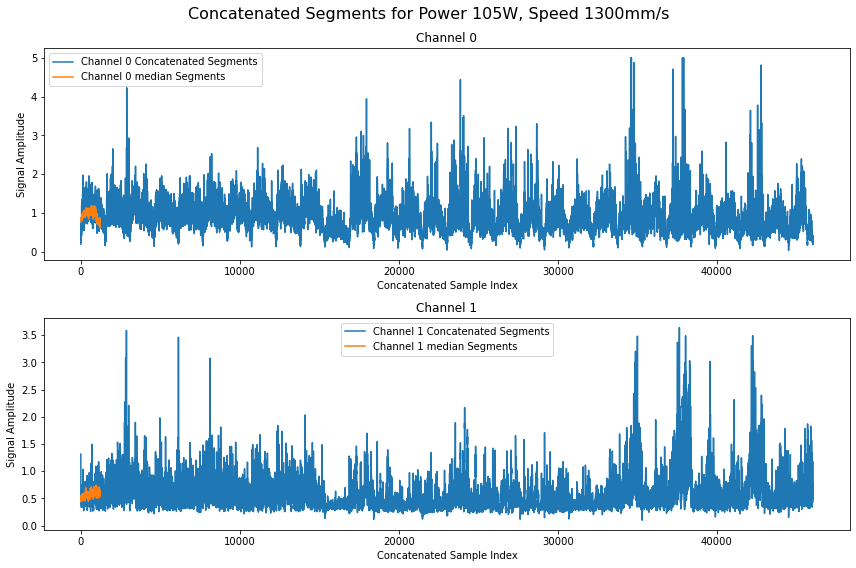

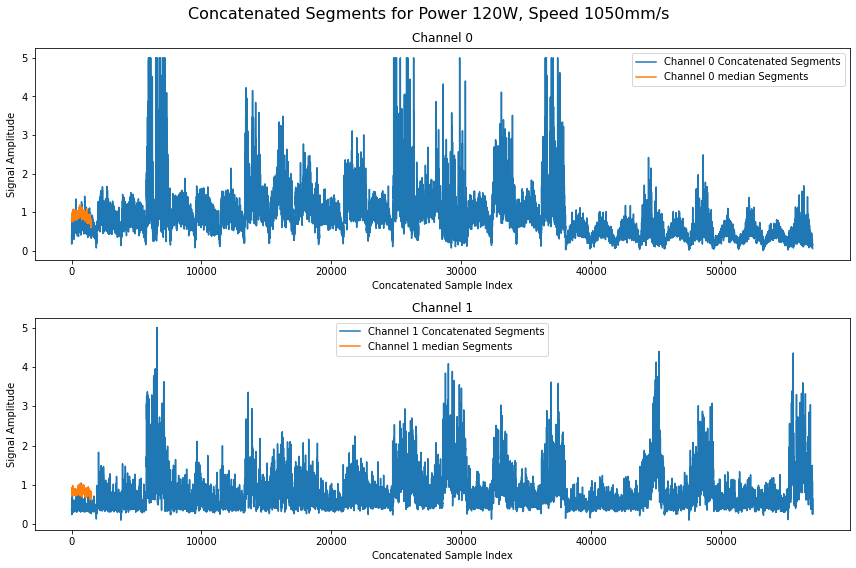

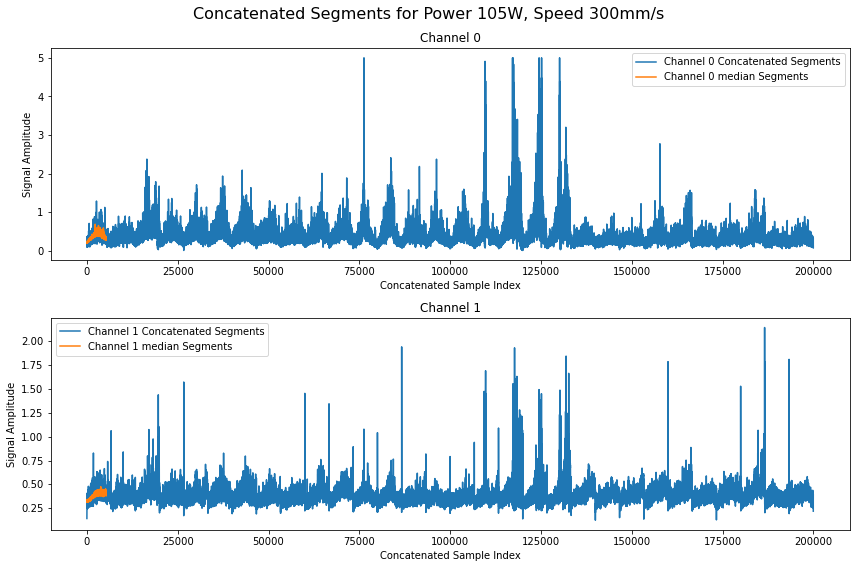

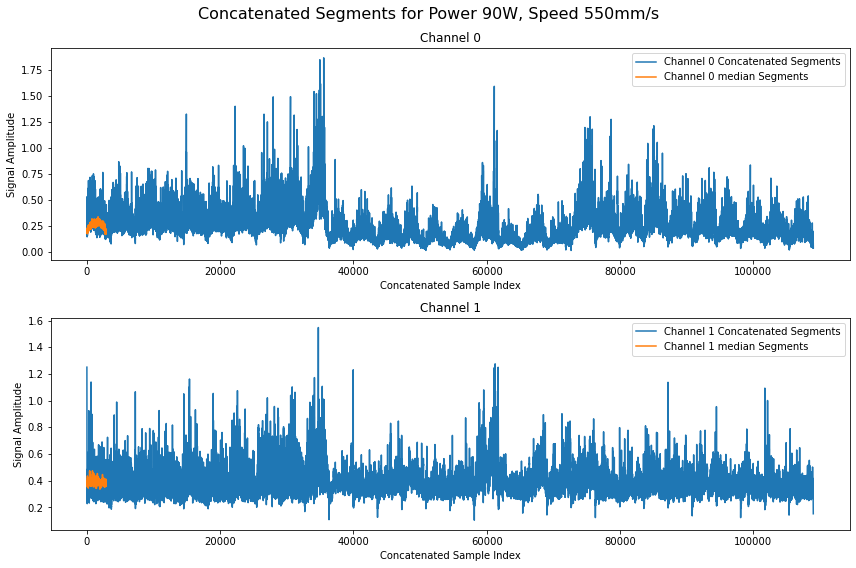

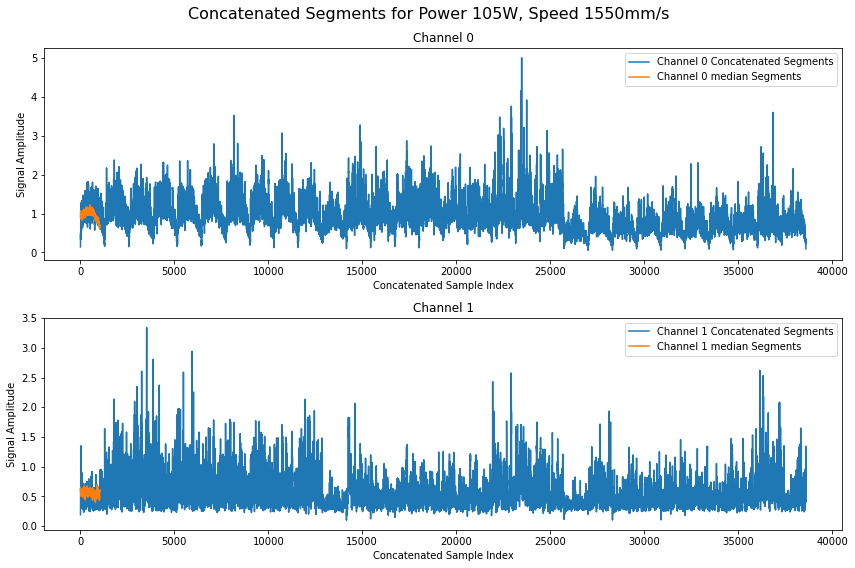

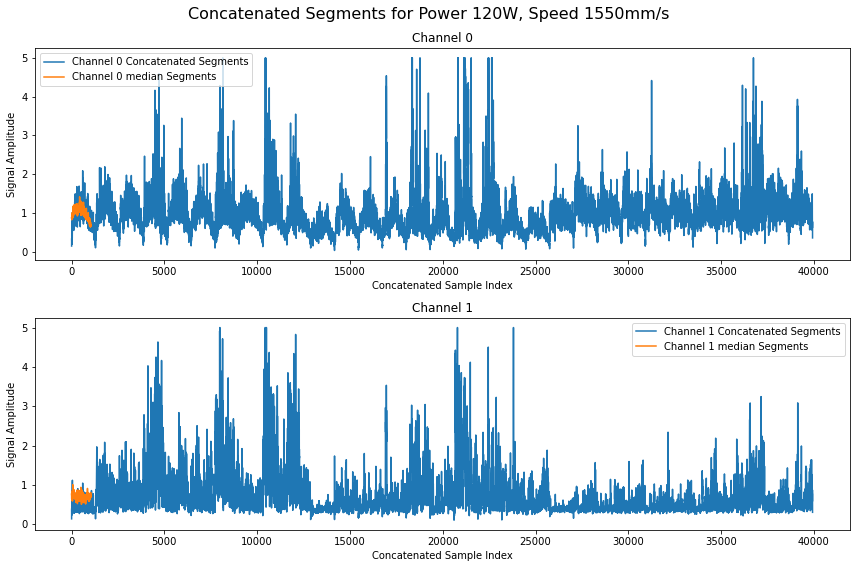

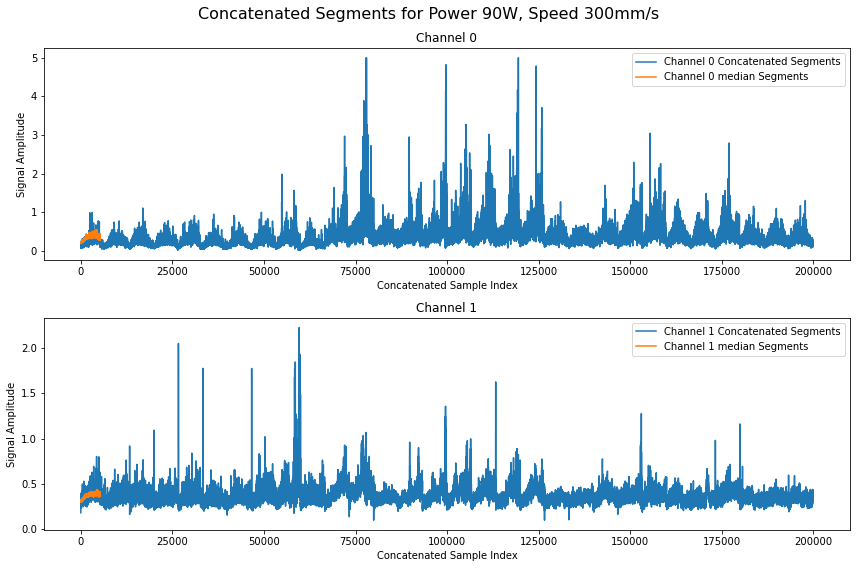

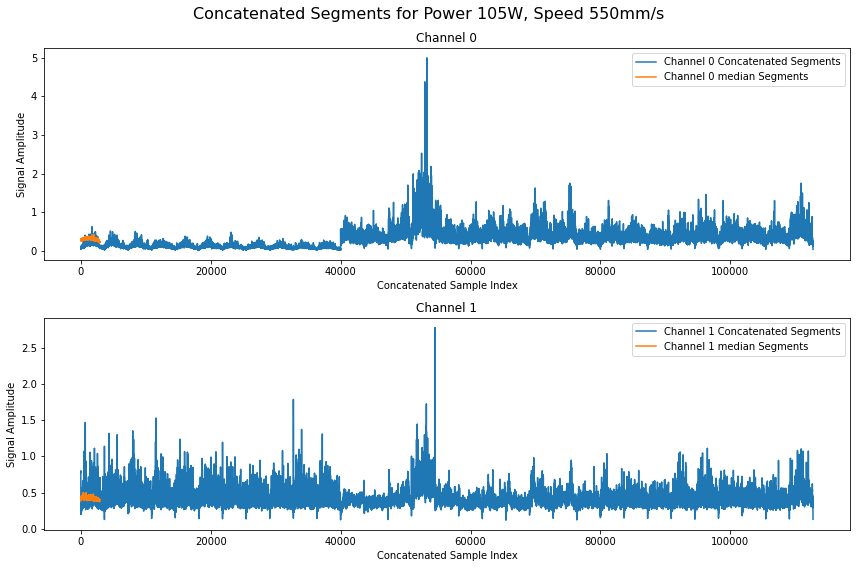

In [40]:
plot_concatenated_segments(segmented_data)

In [41]:
# Define the path where you want to save the dictionary
pickle_file_path = base_path + '/segmented_data_dict_all.pkl'

# Save the dictionary
with open(pickle_file_path, 'wb') as file:
    pickle.dump(segmented_data, file)

print(f'Saved segmented_data_dict to {pickle_file_path}')


Saved segmented_data_dict to ./Data/Neuchatel_316L/segmented_data_dict_all.pkl
